In [1]:
import numpy as np
import pandas as pd

In [2]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb
pd.set_option('display.max_columns', 100)


RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier


#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation



RANDOM_STATE = 2018
MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result


# data understanding
About this file
Training set for Credit Card Transactions
1.index - Unique Identifier for each row
2.transdatetrans_time - Transaction DateTime
3.cc_num - Credit Card Number of Customer
4.merchant - Merchant Name
5.category - Category of Merchant
6.amt - Amount of Transaction
7.first - First Name of Credit Card Holder
8.last - Last Name of Credit Card Holder
9.gender - Gender of Credit Card Holder
10.street - Street Address of Credit Card Holder
11.city - City of Credit Card Holder
12.state - State of Credit Card Holder
13.zip - Zip of Credit Card Holder
14.lat - Latitude Location of Credit Card Holder
15.long - Longitude Location of Credit Card Holder
16.city_pop - Credit Card Holder's City Population
17.job - Job of Credit Card Holder
18.dob - Date of Birth of Credit Card Holder
19.trans_num - Transaction Number
20.unix_time - UNIX Time of transaction
21.merch_lat - Latitude Location of Merchant
22.merch_long - Longitude Location of Merchant
23.is_fraud - Fraud Flag <--- Target Class

In [3]:
df=pd.read_csv('fraudTest.csv',index_col=0)

In [4]:
df

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,NY,11710,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,FL,32780,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,MI,49632,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555714,2020-12-31 23:59:07,30560609640617,fraud_Reilly and Sons,health_fitness,43.77,Michael,Olson,M,558 Michael Estates,Luray,MO,63453,40.4931,-91.8912,519,Town planner,1966-02-13,9b1f753c79894c9f4b71f04581835ada,1388534347,39.946837,-91.333331,0
555715,2020-12-31 23:59:09,3556613125071656,fraud_Hoppe-Parisian,kids_pets,111.84,Jose,Vasquez,M,572 Davis Mountains,Lake Jackson,TX,77566,29.0393,-95.4401,28739,Futures trader,1999-12-27,2090647dac2c89a1d86c514c427f5b91,1388534349,29.661049,-96.186633,0
555716,2020-12-31 23:59:15,6011724471098086,fraud_Rau-Robel,kids_pets,86.88,Ann,Lawson,F,144 Evans Islands Apt. 683,Burbank,WA,99323,46.1966,-118.9017,3684,Musician,1981-11-29,6c5b7c8add471975aa0fec023b2e8408,1388534355,46.658340,-119.715054,0
555717,2020-12-31 23:59:24,4079773899158,fraud_Breitenberg LLC,travel,7.99,Eric,Preston,M,7020 Doyle Stream Apt. 951,Mesa,ID,83643,44.6255,-116.4493,129,Cartographer,1965-12-15,14392d723bb7737606b2700ac791b7aa,1388534364,44.470525,-117.080888,0


In [5]:
df.isnull().sum()

trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [4]:
df.shape

(555719, 22)

In [7]:
df['is_fraud'].value_counts()

0    553574
1      2145
Name: is_fraud, dtype: int64

In [5]:
df1=pd.read_csv('fraudTrain.csv',index_col=0)

C:\Users\DELL\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [7]:
df1

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,2020-06-21 12:12:08,30263540414123,fraud_Reichel Inc,entertainment,15.56,Erik,Patterson,M,162 Jessica Row Apt. 072,Hatch,UT,84735,37.7175,-112.4777,258,Geoscientist,1961-11-24,440b587732da4dc1a6395aba5fb41669,1371816728,36.841266,-111.690765,0
1296671,2020-06-21 12:12:19,6011149206456997,fraud_Abernathy and Sons,food_dining,51.70,Jeffrey,White,M,8617 Holmes Terrace Suite 651,Tuscarora,MD,21790,39.2667,-77.5101,100,"Production assistant, television",1979-12-11,278000d2e0d2277d1de2f890067dcc0a,1371816739,38.906881,-78.246528,0
1296672,2020-06-21 12:12:32,3514865930894695,fraud_Stiedemann Ltd,food_dining,105.93,Christopher,Castaneda,M,1632 Cohen Drive Suite 639,High Rolls Mountain Park,NM,88325,32.9396,-105.8189,899,Naval architect,1967-08-30,483f52fe67fabef353d552c1e662974c,1371816752,33.619513,-105.130529,0
1296673,2020-06-21 12:13:36,2720012583106919,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,Joseph,Murray,M,42933 Ryan Underpass,Manderson,SD,57756,43.3526,-102.5411,1126,Volunteer coordinator,1980-08-18,d667cdcbadaaed3da3f4020e83591c83,1371816816,42.788940,-103.241160,0


# data dictionary

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 555719 entries, 0 to 555718
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trans_date_trans_time  555719 non-null  object 
 1   cc_num                 555719 non-null  int64  
 2   merchant               555719 non-null  object 
 3   category               555719 non-null  object 
 4   amt                    555719 non-null  float64
 5   first                  555719 non-null  object 
 6   last                   555719 non-null  object 
 7   gender                 555719 non-null  object 
 8   street                 555719 non-null  object 
 9   city                   555719 non-null  object 
 10  state                  555719 non-null  object 
 11  zip                    555719 non-null  int64  
 12  lat                    555719 non-null  float64
 13  long                   555719 non-null  float64
 14  city_pop               555719 non-nu

In [6]:
df1.shape

(1296675, 22)

In [7]:
df1.shape

(1296675, 22)

# Variable Categorization

In [6]:
df1_num=df1.select_dtypes(include=[np.number])

In [10]:
df1_num

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
0,2703186189652095,4.97,28654,36.0788,-81.1781,3495,1325376018,36.011293,-82.048315,0
1,630423337322,107.23,99160,48.8878,-118.2105,149,1325376044,49.159047,-118.186462,0
2,38859492057661,220.11,83252,42.1808,-112.2620,4154,1325376051,43.150704,-112.154481,0
3,3534093764340240,45.00,59632,46.2306,-112.1138,1939,1325376076,47.034331,-112.561071,0
4,375534208663984,41.96,24433,38.4207,-79.4629,99,1325376186,38.674999,-78.632459,0
...,...,...,...,...,...,...,...,...,...,...
1296670,30263540414123,15.56,84735,37.7175,-112.4777,258,1371816728,36.841266,-111.690765,0
1296671,6011149206456997,51.70,21790,39.2667,-77.5101,100,1371816739,38.906881,-78.246528,0
1296672,3514865930894695,105.93,88325,32.9396,-105.8189,899,1371816752,33.619513,-105.130529,0
1296673,2720012583106919,74.90,57756,43.3526,-102.5411,1126,1371816816,42.788940,-103.241160,0


In [7]:
df1_cat=df1.select_dtypes(exclude=[np.number])

In [10]:
df1_cat

,trans_date_trans_time,merchant,category,first,last,gender,street,city,state,job,dob,trans_num
0,2019-01-01 00:00:18,"fraud_Rippin, Kub and Mann",misc_net,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9
1,2019-01-01 00:00:44,"fraud_Heller, Gutmann and Zieme",grocery_pos,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99
2,2019-01-01 00:00:51,fraud_Lind-Buckridge,entertainment,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95
3,2019-01-01 00:01:16,"fraud_Kutch, Hermiston and Farrell",gas_transport,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81
4,2019-01-01 00:03:06,fraud_Keeling-Crist,misc_pos,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46
...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,2020-06-21 12:12:08,fraud_Reichel Inc,entertainment,Erik,Patterson,M,162 Jessica Row Apt. 072,Hatch,UT,Geoscientist,1961-11-24,440b587732da4dc1a6395aba5fb41669
1296671,2020-06-21 12:12:19,fraud_Abernathy and Sons,food_dining,Jeffrey,White,M,8617 Holmes Terrace Suite 651,Tuscarora,MD,"Production assistant, television",1979-12-11,278000d2e0d2277d1de2f890067dcc0a
1296672,2020-06-21 12:12:32,fraud_Stiedemann Ltd,food_dining,Christopher,Castaneda,M,1632 Cohen Drive Suite 639,High Rolls Mountain Park,NM,Naval architect,1967-08-30,483f52fe67fabef353d552c1e662974c
1296673,2020-06-21 12:13:36,"fraud_Reinger, Weissnat and Strosin",food_dining,Joseph,Murray,M,42933 Ryan Underpass,Manderson,SD,Volunteer coordinator,1980-08-18,d667cdcbadaaed3da3f4020e83591c83


# count of missing/ null values, redundant columns

In [16]:
df1.isnull().sum()

trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [17]:
df1.head(2)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0


# Alternate sources of data that can supplement core data set

# project Justification

# Data Exploration

# relationship between variables

In [19]:
df1.corr()

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
cc_num,1.000000,0.001769,0.041459,-0.059271,-0.048278,-0.008991,0.000354,-0.058942,-0.048252,-0.000981
amt,0.001769,1.000000,0.001843,-0.001926,-0.000187,0.005818,-0.000293,-0.001873,-0.000151,0.219404
zip,0.041459,0.001843,1.000000,-0.114290,-0.909732,0.078467,0.000670,-0.113561,-0.908924,-0.002162
lat,-0.059271,-0.001926,-0.114290,1.000000,-0.015533,-0.155730,0.000632,0.993592,-0.015509,0.001894
long,-0.048278,-0.000187,-0.909732,-0.015533,1.000000,-0.052715,-0.000642,-0.015452,0.999120,0.001721
city_pop,-0.008991,0.005818,0.078467,-0.155730,-0.052715,1.000000,-0.001714,-0.154781,-0.052687,0.002136
unix_time,0.000354,-0.000293,0.000670,0.000632,-0.000642,-0.001714,1.000000,0.000561,-0.000635,-0.005078
merch_lat,-0.058942,-0.001873,-0.113561,0.993592,-0.015452,-0.154781,0.000561,1.000000,-0.015431,0.001741
merch_long,-0.048252,-0.000151,-0.908924,-0.015509,0.999120,-0.052687,-0.000635,-0.015431,1.000000,0.001721
is_fraud,-0.000981,0.219404,-0.002162,0.001894,0.001721,0.002136,-0.005078,0.001741,0.001721,1.000000


In [20]:
plt.rcParams['figure.figsize']=(20,20)

<AxesSubplot:>

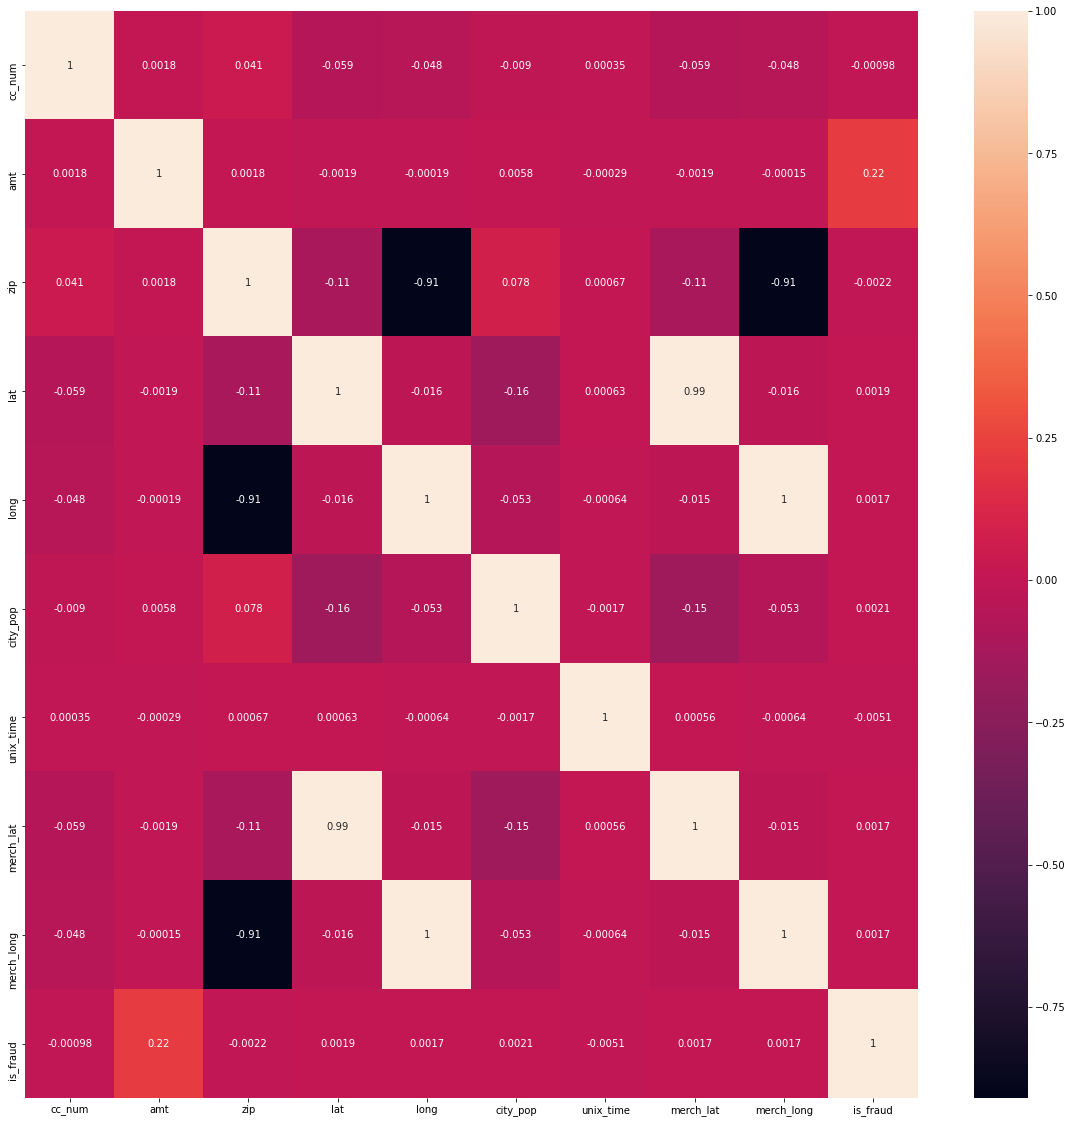

In [21]:
sns.heatmap(df1.corr(),annot=True)

# 1.Multi collinearity

In [8]:
df1_n=df1_num.drop(['cc_num','is_fraud'],axis=1)
df1_n

,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long
0,4.97,28654,36.0788,-81.1781,3495,1325376018,36.011293,-82.048315
1,107.23,99160,48.8878,-118.2105,149,1325376044,49.159047,-118.186462
2,220.11,83252,42.1808,-112.2620,4154,1325376051,43.150704,-112.154481
3,45.00,59632,46.2306,-112.1138,1939,1325376076,47.034331,-112.561071
4,41.96,24433,38.4207,-79.4629,99,1325376186,38.674999,-78.632459
...,...,...,...,...,...,...,...,...
1296670,15.56,84735,37.7175,-112.4777,258,1371816728,36.841266,-111.690765
1296671,51.70,21790,39.2667,-77.5101,100,1371816739,38.906881,-78.246528
1296672,105.93,88325,32.9396,-105.8189,899,1371816752,33.619513,-105.130529
1296673,74.90,57756,43.3526,-102.5411,1126,1371816816,42.788940,-103.241160


In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X=df1_n
vif = pd.DataFrame()
vif["VIF_Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Features"] = X.columns
print(vif)

   VIF_Factor    Features
0    1.000025         amt
1    6.381240         zip
2   78.405727         lat
3  573.496917        long
4    1.028612    city_pop
5  164.933928   unix_time
6   78.282734   merch_lat
7  568.163012  merch_long


In [24]:
vif.sort_values('VIF_Factor',ascending=False)

,VIF_Factor,Features
3,573.496917,long
7,568.163012,merch_long
5,164.933928,unix_time
2,78.405727,lat
6,78.282734,merch_lat
1,6.381240,zip
4,1.028612,city_pop
0,1.000025,amt


# 2. Distribution of variables
    

array([[<AxesSubplot:title={'center':'amt'}>,
        <AxesSubplot:title={'center':'zip'}>,
        <AxesSubplot:title={'center':'lat'}>],
       [<AxesSubplot:title={'center':'long'}>,
        <AxesSubplot:title={'center':'city_pop'}>,
        <AxesSubplot:title={'center':'unix_time'}>],
       [<AxesSubplot:title={'center':'merch_lat'}>,
        <AxesSubplot:title={'center':'merch_long'}>, <AxesSubplot:>]],
      dtype=object)

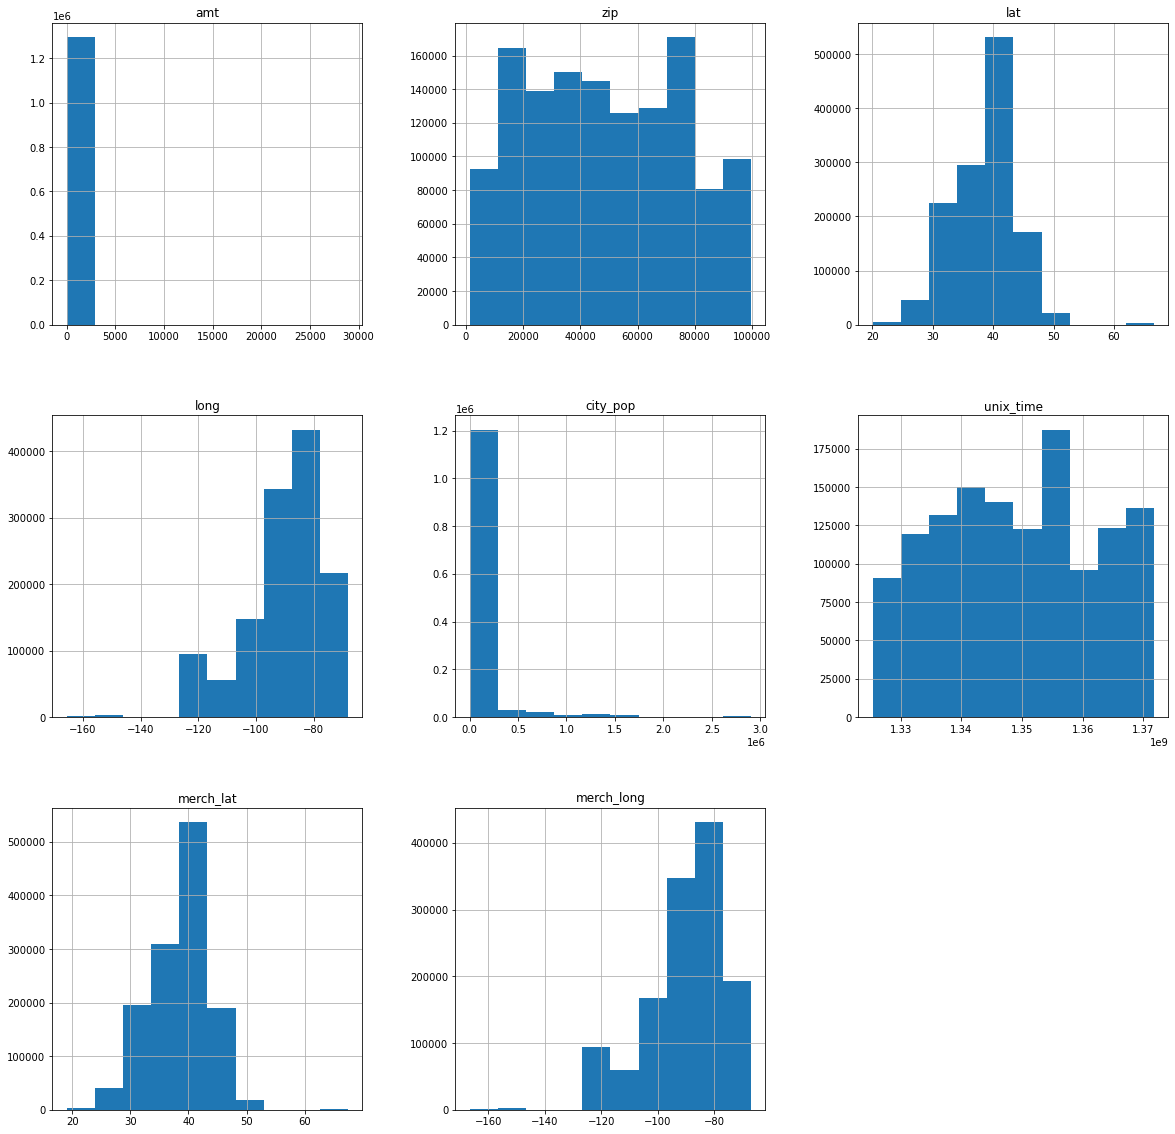

In [25]:
df1_num.drop(['cc_num','is_fraud'],axis=1).hist()

# 3.Presence of outliers and its treatment

In [14]:
df1_n.columns

Index(['amt', 'zip', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat',
       'merch_long'],
      dtype='object')

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: Future

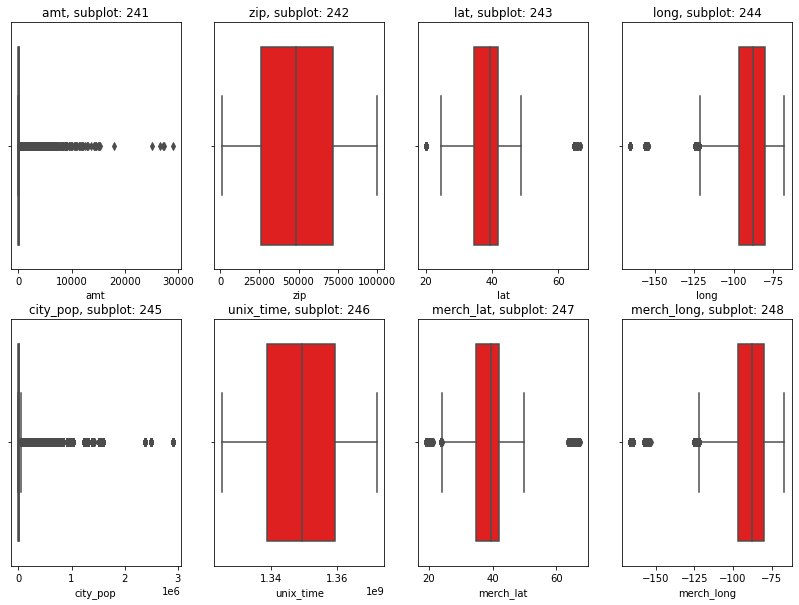

In [27]:
heart_CAT = ['amt', 'zip', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat',
       'merch_long']

a = 2  
b = 4  
c = 1  

fig = plt.figure(figsize=(14,10))

for i in heart_CAT:
    plt.subplot(a, b, c)
    plt.title('{}, subplot: {}{}{}'.format(i, a, b, c))
    plt.xlabel(i)
    sns.boxplot(df1_n[i],color='red')
    c = c + 1

plt.show()

# univariate analysis for numerical columns

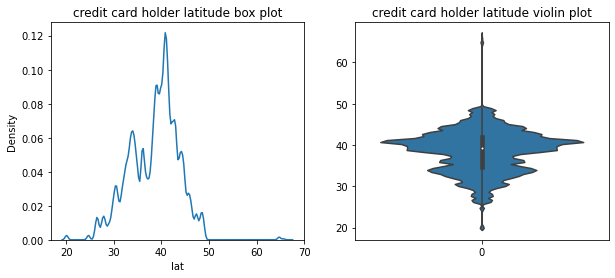

In [28]:
fig = plt.figure(figsize=(10,4))

#  subplot #1
plt.subplot(121)
plt.title('credit card holder latitude box plot')
sns.kdeplot(data=df1_n['lat'])

#  subplot #2
plt.subplot(122)
plt.title('credit card holder latitude violin plot')
sns.violinplot(data=df1_n['lat'])

plt.show()

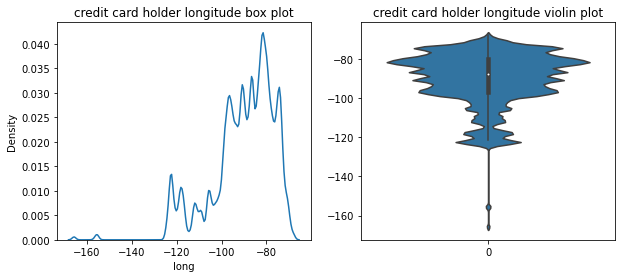

In [29]:
fig = plt.figure(figsize=(10,4))

#  subplot #1
plt.subplot(121)
plt.title('credit card holder longitude box plot')
sns.kdeplot(data=df1_n['long'])

#  subplot #2
plt.subplot(122)
plt.title('credit card holder longitude violin plot')
sns.violinplot(data=df1_n['long'])

plt.show()

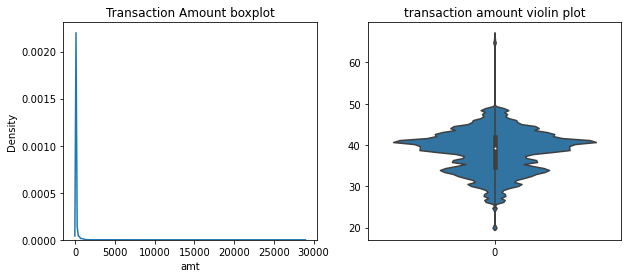

In [30]:
fig = plt.figure(figsize=(10,4))

#  subplot #1
plt.subplot(121)
plt.title('Transaction Amount boxplot')
sns.kdeplot(data=df1_n['amt'])

#  subplot #2
plt.subplot(122)
plt.title('transaction amount violin plot')
sns.violinplot(data=df1_n['lat'])

plt.show()

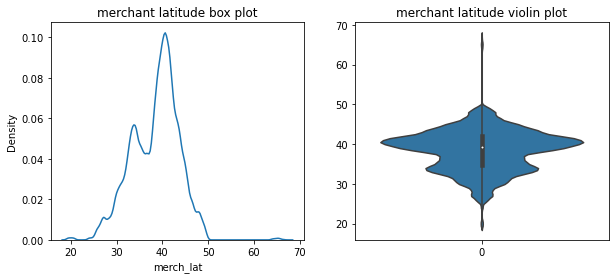

In [31]:
fig = plt.figure(figsize=(10,4))

#  subplot #1
plt.subplot(121)
plt.title('merchant latitude box plot')
sns.kdeplot(data=df1_n['merch_lat'])

#  subplot #2
plt.subplot(122)
plt.title('merchant latitude violin plot')
sns.violinplot(data=df1_n['merch_lat'])

plt.show()

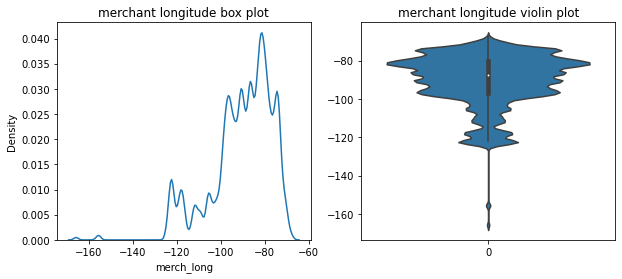

In [32]:
fig = plt.figure(figsize=(10,4))

#  subplot #1
plt.subplot(121)
plt.title('merchant longitude box plot')
sns.kdeplot(data=df1_n['merch_long'])

#  subplot #2
plt.subplot(122)
plt.title('merchant longitude violin plot')
sns.violinplot(data=df1_n['merch_long'])

plt.show()

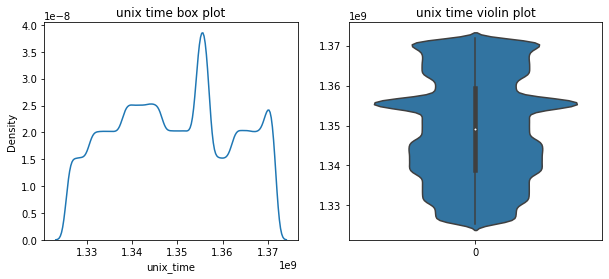

In [33]:
fig = plt.figure(figsize=(10,4))

#  subplot #1
plt.subplot(121)
plt.title('unix time box plot')
sns.kdeplot(data=df1_n['unix_time'])

#  subplot #2
plt.subplot(122)
plt.title('unix time violin plot')
sns.violinplot(data=df1_n['unix_time'])

plt.show()

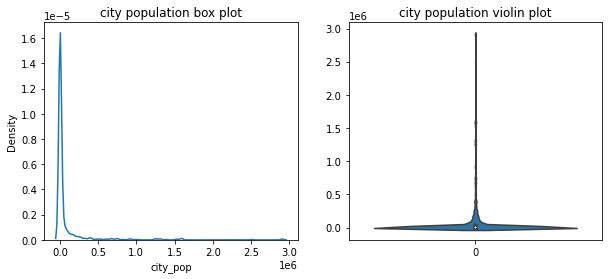

In [34]:
fig = plt.figure(figsize=(10,4))

#  subplot #1
plt.subplot(121)
plt.title('city population box plot')
sns.kdeplot(data=df1_n['city_pop'])

#  subplot #2
plt.subplot(122)
plt.title('city population violin plot')
sns.violinplot(data=df1_n['city_pop'])

plt.show()

In [20]:
df1_n.columns

Index(['amt', 'zip', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat',
       'merch_long'],
      dtype='object')

# univariate analysis for categorical columns

# top 10 merchants out of 800

In [36]:
df1_cat['merchant'].value_counts().head(10)

fraud_Kilback LLC                   4403
fraud_Cormier LLC                   3649
fraud_Schumm PLC                    3634
fraud_Kuhn LLC                      3510
fraud_Boyer PLC                     3493
fraud_Dickinson Ltd                 3434
fraud_Cummerata-Jones               2736
fraud_Kutch LLC                     2734
fraud_Olson, Becker and Koch        2723
fraud_Stroman, Hudson and Erdman    2721
Name: merchant, dtype: int64

In [17]:
temp = df1["merchant"].value_counts().head(10)
df = pd.DataFrame({'Class': temp.index,'values': temp.values})

trace = go.Bar(
    x = df['Class'],y = df['values'],
    name="Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)",
    marker=dict(color="Red"),
    text=df['values']
)
data = [trace]
layout = dict(title = 'Merchant Category univariate analysis',
          xaxis = dict(title = 'merchant', showticklabels=True), 
          yaxis = dict(title = 'count'),
          hovermode = 'closest',width=600
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='class')

# category of merchants

In [38]:
df1_cat['category'].value_counts().head()

gas_transport    131659
grocery_pos      123638
home             123115
shopping_pos     116672
kids_pets        113035
Name: category, dtype: int64

In [18]:
temp = df1["category"].value_counts().head(10)
df = pd.DataFrame({'Class': temp.index,'values': temp.values})

trace = go.Bar(
    x = df['Class'],y = df['values'],
    name="Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)",
    marker=dict(color="Red"),
    text=df['values']
)
data = [trace]
layout = dict(title = 'category univariate analysis',
          xaxis = dict(title = 'category', showticklabels=True), 
          yaxis = dict(title = 'count'),
          hovermode = 'closest',width=600
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='class')

# top 10 cities of credit card holder

In [40]:
df1_cat['city'].value_counts().head(10)

Birmingham     5617
San Antonio    5130
Utica          5105
Phoenix        5075
Meridian       5060
Thomas         4634
Conway         4613
Cleveland      4604
Warren         4599
Houston        4168
Name: city, dtype: int64

In [19]:
temp = df1["city"].value_counts().head(10)
df = pd.DataFrame({'Class': temp.index,'values': temp.values})

trace = go.Bar(
    x = df['Class'],y = df['values'],
    name="Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)",
    marker=dict(color="Red"),
    text=df['values']
)
data = [trace]
layout = dict(title = 'city univariate analysis',
          xaxis = dict(title = 'city', showticklabels=True), 
          yaxis = dict(title = 'count'),
          hovermode = 'closest',width=600
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='class')

# top 10 state of credit card holder

In [21]:
df1_cat['state'].value_counts().head(10)

TX    94876
NY    83501
PA    79847
CA    56360
OH    46480
MI    46154
IL    43252
FL    42671
AL    40989
MO    38403
Name: state, dtype: int64

In [20]:
temp = df1["state"].value_counts().head(10)
df = pd.DataFrame({'Class': temp.index,'values': temp.values})

trace = go.Bar(
    x = df['Class'],y = df['values'],
    name="Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)",
    marker=dict(color="Red"),
    text=df['values']
)
data = [trace]
layout = dict(title = 'state univariate analysis',
          xaxis = dict(title = 'state', showticklabels=True), 
          yaxis = dict(title = 'count'),
          hovermode = 'closest',width=600
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='class')

# top 10 jobs of credit card holder

In [44]:
df1_cat['job'].value_counts().head(50)

Film/video editor                                    9779
Exhibition designer                                  9199
Naval architect                                      8684
Surveyor, land/geomatics                             8680
Materials engineer                                   8270
Designer, ceramics/pottery                           8225
Systems developer                                    7700
IT trainer                                           7679
Financial adviser                                    7659
Environmental consultant                             7547
Chartered public finance accountant                  7210
Scientist, audiological                              7174
Chief Executive Officer                              7172
Copywriter, advertising                              7146
Comptroller                                          6730
Sub                                                  6701
Podiatrist                                           6653
Agricultural c

In [21]:
temp = df1["job"].value_counts().head(10)
df = pd.DataFrame({'Class': temp.index,'values': temp.values})

trace = go.Bar(
    x = df['Class'],y = df['values'],
    name="Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)",
    marker=dict(color="Red"),
    text=df['values']
)
data = [trace]
layout = dict(title = 'job univariate analysis',
          xaxis = dict(title = 'job', showticklabels=True), 
          yaxis = dict(title = 'count'),
          hovermode = 'closest',width=600
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='class')

# statistical insights

In [46]:
df1.describe()

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06
mean,4.171920e+17,7.035104e+01,4.880067e+04,3.853762e+01,-9.022634e+01,8.882444e+04,1.349244e+09,3.853734e+01,-9.022646e+01,5.788652e-03
std,1.308806e+18,1.603160e+02,2.689322e+04,5.075808e+00,1.375908e+01,3.019564e+05,1.284128e+07,5.109788e+00,1.377109e+01,7.586269e-02
min,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902779e+01,-1.666712e+02,0.000000e+00
25%,1.800429e+14,9.650000e+00,2.623700e+04,3.462050e+01,-9.679800e+01,7.430000e+02,1.338751e+09,3.473357e+01,-9.689728e+01,0.000000e+00
50%,3.521417e+15,4.752000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.456000e+03,1.349250e+09,3.936568e+01,-8.743839e+01,0.000000e+00
75%,4.642255e+15,8.314000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.359385e+09,4.195716e+01,-8.023680e+01,0.000000e+00
max,4.992346e+18,2.894890e+04,9.978300e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.371817e+09,6.751027e+01,-6.695090e+01,1.000000e+00


In [47]:
df1.std()

cc_num        1.308806e+18
amt           1.603160e+02
zip           2.689322e+04
lat           5.075808e+00
long          1.375908e+01
city_pop      3.019564e+05
unix_time     1.284128e+07
merch_lat     5.109788e+00
merch_long    1.377109e+01
is_fraud      7.586269e-02
dtype: float64

# checking the data imbalance ratio

In [9]:
target0 = df1.loc[df1['is_fraud']==0]
target1 = df1.loc[df1['is_fraud']==1]

In [49]:
df1['is_fraud'].value_counts()
(df1['is_fraud'].value_counts()/len(df1['is_fraud']))*100

0    99.421135
1     0.578865
Name: is_fraud, dtype: float64

In [50]:
round(len(target0)/len(target1),2)

171.75

In [13]:
m=df1['is_fraud'].value_counts()

In [14]:
import plotly.express as px
import numpy
 
# Random Data
random_x = m.values
names = m.index
 
fig = px.pie(values=random_x, names=names,title='Credit card transaction -data imbalance')
fig.show()

In [22]:
temp = df1["is_fraud"].value_counts()
df = pd.DataFrame({'Class': temp.index,'values': temp.values})

trace = go.Bar(
    x = df['Class'],y = df['values'],
    name="Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)",
    marker=dict(color="Red"),
    text=df['values']
)
data = [trace]
layout = dict(title = 'Credit Card Fraud Class - data unbalance (Notfraud= 0,Fraud =1)',
          xaxis = dict(title = 'Class', showticklabels=True), 
          yaxis = dict(title = 'Number of transactions'),
          hovermode = 'closest',width=600
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='class')

# inference:
    df1 dataframe that is application data is highly imbalanced .
    'defaulted population is 0.57% and non defaulted population ois 99.4%'

we will seperately analyse the data based in the target variable for a better understanding

# bivariate analysis 

# gender percenatge

In [26]:
df_gender=(df1['gender'].value_counts()/len(df1['gender']))*100

In [23]:
temp = df1["gender"].value_counts()
df = pd.DataFrame({'Class': temp.index,'values': temp.values})

trace = go.Bar(
    x = df['Class'],y = df['values'],
    name="Credit Card Transaction - Gender Wise Analysis",
    marker=dict(color="Green"),
    text=df['values']
)
data = [trace]
layout = dict(title = "Credit Card Transaction - Gender Wise Analysis",
          xaxis = dict(title = 'Gender', showticklabels=True), 
          yaxis = dict(title = 'Number of transactions'),
          hovermode = 'closest',width=600
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='class')

In [56]:
pd.crosstab(target0['gender'],target0['is_fraud'])

is_fraud,0
gender,
F,706128
M,583041


In [57]:
target0['gender'].value_counts()

F    706128
M    583041
Name: gender, dtype: int64

In [58]:
target0.groupby("gender")["is_fraud"].count()

gender
F    706128
M    583041
Name: is_fraud, dtype: int64

In [59]:
(target0.groupby("gender")["is_fraud"].count())/(len(df1['is_fraud']))*100

gender
F    54.456822
M    44.964313
Name: is_fraud, dtype: float64

In [60]:
(target1.groupby("gender")["is_fraud"].count())/(len(df1['is_fraud']))*100

gender
F    0.288044
M    0.290821
Name: is_fraud, dtype: float64

In [61]:
plt.rcParams['figure.figsize']=(15,5)

Text(0, 0.5, 'Fraud transactions')

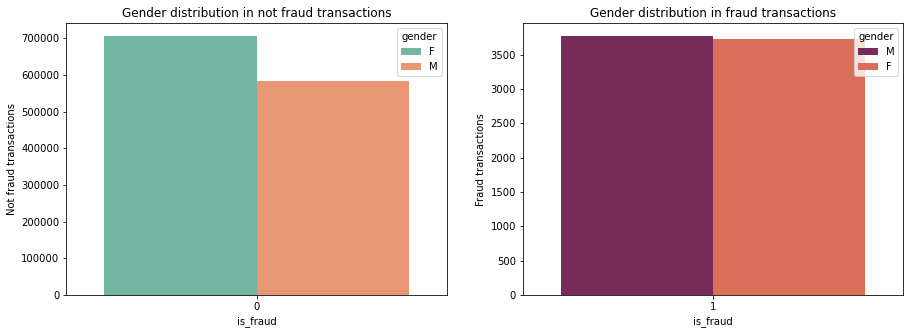

In [62]:
plt.subplot(121)
sns.countplot(x='is_fraud',hue='gender',data=target0,palette='Set2')
plt.title('Gender distribution in not fraud transactions')
plt.ylabel('Not fraud transactions')
plt.subplot(122)
sns.countplot(x='is_fraud',hue='gender',data=target1,palette='rocket')
plt.title('Gender distribution in fraud transactions')
plt.ylabel('Fraud transactions')

# insights 

*it seems like female clients done more transaction than male customers
*54.45% female clients are non defaulters while 44.96% male clients are non defaulters
*0.28% female clients are defaulters and 0.29% male clients are defaulters

# binning dob 

In [10]:
import datetime

In [11]:
df1['dob']=pd.to_datetime(df1['dob'])

In [27]:
df.head(2)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0


In [12]:
df['dob']=pd.to_datetime(df['dob'])

In [13]:
df1['dob']

0         1988-03-09
1         1978-06-21
2         1962-01-19
3         1967-01-12
4         1986-03-28
             ...    
1296670   1961-11-24
1296671   1979-12-11
1296672   1967-08-30
1296673   1980-08-18
1296674   1995-08-16
Name: dob, Length: 1296675, dtype: datetime64[ns]

In [14]:
df1['year']=pd.DatetimeIndex(df1['dob']).year

In [15]:
df['year']=pd.DatetimeIndex(df['dob']).year

In [16]:
df1['year']=2022-df1['year']

In [17]:
df['year']=2022-df['year']

In [34]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   trans_date_trans_time  1296675 non-null  object        
 1   cc_num                 1296675 non-null  int64         
 2   merchant               1296675 non-null  object        
 3   category               1296675 non-null  object        
 4   amt                    1296675 non-null  float64       
 5   first                  1296675 non-null  object        
 6   last                   1296675 non-null  object        
 7   gender                 1296675 non-null  object        
 8   street                 1296675 non-null  object        
 9   city                   1296675 non-null  object        
 10  state                  1296675 non-null  object        
 11  zip                    1296675 non-null  int64         
 12  lat                    12966

In [32]:
df1['year'].unique()

array([34, 44, 60, 55, 36, 61, 29, 75, 81, 48, 32, 56, 33, 77, 57, 70, 84,
       76, 42, 51, 58, 45, 52, 38, 24, 35, 80, 50, 62, 68, 28, 46, 41, 96,
       86, 25, 67, 39, 43, 22, 65, 40, 87, 47, 27, 95, 94, 72, 64, 71, 37,
       21, 93, 59, 74, 54, 49, 63, 23, 19, 53, 91, 82, 88, 30, 83, 69, 66,
       18, 17, 85, 89, 26, 78, 31, 73, 79, 92, 90, 98, 97], dtype=int64)

In [18]:
def function_mrp(a):
    if a <=25 :
        return 'Very young age'
    if a > 25 and a <= 35:
        return 'Young age'
    if a > 35 and a <= 45:
        return 'Middle age'
    else:
        return 'Senior citizen'

In [19]:
df1['age_group'] = df1['year'].apply(function_mrp)

In [20]:
df['age_group'] = df['year'].apply(function_mrp)

In [21]:
df.head(2)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,year,age_group
0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0,54,Senior citizen
1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0,32,Young age


In [22]:
target0 = df1.loc[df1['is_fraud']==0]
target1 = df1.loc[df1['is_fraud']==1]

In [46]:
df1

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,year,age_group
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,34,Young age
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,44,Middle age
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,60,Senior citizen
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,55,Senior citizen
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,36,Middle age
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,2020-06-21 12:12:08,30263540414123,fraud_Reichel Inc,entertainment,15.56,Erik,Patterson,M,162 Jessica Row Apt. 072,Hatch,UT,84735,37.7175,-112.4777,258,Geoscientist,1961-11-24,440b587732da4dc1a6395aba5fb41669,1371816728,36.841266,-111.690765,0,61,Senior citizen
1296671,2020-06-21 12:12:19,6011149206456997,fraud_Abernathy and Sons,food_dining,51.70,Jeffrey,White,M,8617 Holmes Terrace Suite 651,Tuscarora,MD,21790,39.2667,-77.5101,100,"Production assistant, television",1979-12-11,278000d2e0d2277d1de2f890067dcc0a,1371816739,38.906881,-78.246528,0,43,Middle age
1296672,2020-06-21 12:12:32,3514865930894695,fraud_Stiedemann Ltd,food_dining,105.93,Christopher,Castaneda,M,1632 Cohen Drive Suite 639,High Rolls Mountain Park,NM,88325,32.9396,-105.8189,899,Naval architect,1967-08-30,483f52fe67fabef353d552c1e662974c,1371816752,33.619513,-105.130529,0,55,Senior citizen
1296673,2020-06-21 12:13:36,2720012583106919,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,Joseph,Murray,M,42933 Ryan Underpass,Manderson,SD,57756,43.3526,-102.5411,1126,Volunteer coordinator,1980-08-18,d667cdcbadaaed3da3f4020e83591c83,1371816816,42.788940,-103.241160,0,42,Middle age


In [37]:
target0

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,2020-06-21 12:12:08,30263540414123,fraud_Reichel Inc,entertainment,15.56,Erik,Patterson,M,162 Jessica Row Apt. 072,Hatch,UT,84735,37.7175,-112.4777,258,Geoscientist,1961-11-24,440b587732da4dc1a6395aba5fb41669,1371816728,36.841266,-111.690765,0
1296671,2020-06-21 12:12:19,6011149206456997,fraud_Abernathy and Sons,food_dining,51.70,Jeffrey,White,M,8617 Holmes Terrace Suite 651,Tuscarora,MD,21790,39.2667,-77.5101,100,"Production assistant, television",1979-12-11,278000d2e0d2277d1de2f890067dcc0a,1371816739,38.906881,-78.246528,0
1296672,2020-06-21 12:12:32,3514865930894695,fraud_Stiedemann Ltd,food_dining,105.93,Christopher,Castaneda,M,1632 Cohen Drive Suite 639,High Rolls Mountain Park,NM,88325,32.9396,-105.8189,899,Naval architect,1967-08-30,483f52fe67fabef353d552c1e662974c,1371816752,33.619513,-105.130529,0
1296673,2020-06-21 12:13:36,2720012583106919,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,Joseph,Murray,M,42933 Ryan Underpass,Manderson,SD,57756,43.3526,-102.5411,1126,Volunteer coordinator,1980-08-18,d667cdcbadaaed3da3f4020e83591c83,1371816816,42.788940,-103.241160,0


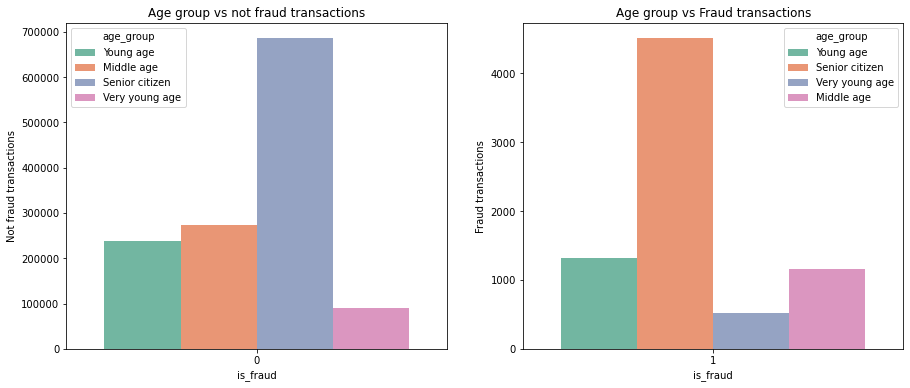

In [75]:
plt.figure(figsize=(15,6))
plt.subplot(121)
sns.countplot(x='is_fraud',hue='age_group',data=target0,palette='Set2')
plt.title('Age group vs not fraud transactions')
plt.ylabel('Not fraud transactions')
plt.subplot(122)
sns.countplot(x='is_fraud',hue='age_group',data=target1,palette='Set2')
plt.title('Age group vs Fraud transactions')
plt.ylabel('Fraud transactions')
plt.show()

Insights
*senior citizen above 60 are higher than any other in case of defaulters as well as non defaulters
*also senior citizens age group facing paying difficulties are the most
*while middle age group and very young age group facing less difficulties in paying

# job distribution based on target0 and target1

In [47]:
temp = target0["job"].value_counts().head(10)
df = pd.DataFrame({'Class': temp.index,'values': temp.values})

trace = go.Bar(
    x = df['Class'],y = df['values'],
    name="Credit Card Transaction - job Wise Analysis target0",
    marker=dict(color="blue"),
    text=df['values']
)
data = [trace]
layout = dict(title ="Credit Card Transaction - job Wise Analysis target0",
          xaxis = dict(title = 'job', showticklabels=True), 
          yaxis = dict(title = 'Number of transactions'),
          hovermode = 'closest',width=600
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='class')

#inference
1.jobs such as film editor , agriculture consultant, financial trader are quitely the non defaulters in credit card transaction

In [48]:
temp = target1["job"].value_counts().head(10)
df = pd.DataFrame({'Class': temp.index,'values': temp.values})

trace = go.Bar(
    x = df['Class'],y = df['values'],
    name="Credit Card Transaction - job Wise Analysis target1",
    marker=dict(color="red"),
    text=df['values']
)
data = [trace]
layout = dict(title ="job category wise analysis  for fraud transaction",
          xaxis = dict(title = 'job categories', showticklabels=True), 
          yaxis = dict(title = 'Number of transactions'),
          hovermode = 'closest',width=600
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='class')

# inference
1.jobs such as materials engineer , podiatrist, energy engineer are quitely the defaulters in credit card transaction

# merchant category vs fraud or not fraud

In [49]:
df_category=pd.crosstab(df1['category'],df1['is_fraud'])

In [50]:
df_c=df_category.reset_index()

In [51]:
df_c.rename(columns={'is_fraud':'index',0:'not_fraud',1:'fraud'},inplace=True)

In [52]:
df_c=df_c.sort_values('fraud',ascending=False)

In [53]:
from plotly.subplots import make_subplots 
import plotly.graph_objects as go


fig = make_subplots(rows=1, cols=2, shared_yaxes=True,subplot_titles=('Merchant category vs not fraud counts',"Merchant  category vs fraud counts"))

fig.add_trace(go.Bar(x=df_c['category'], y=df_c['not_fraud'],
                    marker=dict(color=df_c['not_fraud'], coloraxis="coloraxis")),
              1, 1)

fig.add_trace(go.Bar(x=df_c['category'], y=df_c['fraud'],
                    marker=dict( color=df_c['fraud'],coloraxis="coloraxis")),
              1, 2)

fig['layout']['xaxis']['title']='merchant categories'
fig['layout']['xaxis2']['title']='merchant categories'
fig['layout']['yaxis']['title']='not fraud counts'
fig['layout']['yaxis2']['title']='fraud counts'

fig.update_layout(coloraxis=dict(colorscale='viridis'), showlegend=False)
fig.show()

# insights 
*merchant categories such as gas_transport,home,grocery_pos, shopping_pos has high non fraud transactions
*merchant categories such as grocery_pos,shopping_net,misc_net, shopping_pos has fraud transactions

# cities of credit card holder vs fraud or not fraud counts 

In [83]:
df1['city'].value_counts().head(10)

Birmingham     5617
San Antonio    5130
Utica          5105
Phoenix        5075
Meridian       5060
Thomas         4634
Conway         4613
Cleveland      4604
Warren         4599
Houston        4168
Name: city, dtype: int64

In [54]:
df_city=pd.crosstab(df1['city'],df1['is_fraud'])

In [55]:
df_city.reset_index(inplace=True)

In [56]:
df_city.rename(columns={0:'not_fraud',1:'fraud'},inplace=True)

In [57]:
df_city=df_city.sort_values('fraud',ascending=False)

In [58]:
df_city = df_city.head(10)

In [59]:
df_city

is_fraud,city,not_fraud,fraud
359,Houston,4129,39
837,Warren,4566,33
554,Naples,4126,29
368,Huntsville,3531,29
806,Topeka,3001,27
193,Dallas,3602,27
810,Tulsa,3059,27
212,Detroit,3558,26
725,San Antonio,5105,25
676,Randolph,1517,25


In [60]:
from plotly.subplots import make_subplots 
import plotly.graph_objects as go


fig = make_subplots(rows=1, cols=2, shared_yaxes=True,subplot_titles=('cities of credit card holder vs not fraud counts',"cities of credit card holder vs fraud counts"))

fig.add_trace(go.Bar(x=df_city['city'], y=df_city['not_fraud'],
                    marker=dict(color=df_city['not_fraud'], coloraxis="coloraxis")),
              1, 1)

fig.add_trace(go.Bar(x=df_city['city'], y=df_city['fraud'],
                    marker=dict( color=df_city['fraud'],coloraxis="coloraxis")),
              1, 2)

fig['layout']['xaxis']['title']='cities of credit card holder'
fig['layout']['xaxis2']['title']='cities of credit card holder'
fig['layout']['yaxis']['title']='not fraud counts'
fig['layout']['yaxis2']['title']='fraud counts'

fig.update_layout(coloraxis=dict(colorscale='Bluered_r'), showlegend=False)
fig.show()

# insights:
1.we can clearly see that san Antonio city has the highest non fraud transaction where as huston city has the highest fraud transaction

In [61]:
temp = target0["city"].value_counts().head(10)
df = pd.DataFrame({'Class': temp.index,'values': temp.values})

trace = go.Bar(
    x = df['Class'],y = df['values'],
    name='cities of credit card holder vs not fraud counts',
    marker=dict(color="green"),
    text=df['values']
)
data = [trace]
layout = dict(title ='cities of credit card holder vs not fraud counts',
          xaxis = dict(title = 'city', showticklabels=True), 
          yaxis = dict(title = 'Number of transactions'),
          hovermode = 'closest',width=600
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='class')

In [62]:
temp = target1["city"].value_counts().head(10)
df = pd.DataFrame({'Class': temp.index,'values': temp.values})

trace = go.Bar(
    x = df['Class'],y = df['values'],
    name='cities of credit card holder vs  fraud counts',
    marker=dict(color="red"),
    text=df['values']
)
data = [trace]
layout = dict(title ='cities of credit card holder vs fraud counts',
          xaxis = dict(title = 'city', showticklabels=True), 
          yaxis = dict(title = 'Number of transactions'),
          hovermode = 'closest',width=600
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='class')

# top 10 merchants vs fraud transactions and not fraud transactions

In [93]:
plt.rcParams['figure.figsize']=(15,8)

In [63]:
temp = target0["merchant"].value_counts().head(10)
df = pd.DataFrame({'Class': temp.index,'values': temp.values})

trace = go.Bar(
    x = df['Class'],y = df['values'],
    name=' top 10 merchants vs not fraud transactions',
    marker=dict(color="green"),
    text=df['values']
)
data = [trace]
layout = dict(title ='top 10 merchants vs not fraud transactions',
          xaxis = dict(title = 'merchant', showticklabels=True), 
          yaxis = dict(title = 'Number of non fraud transactions'),
          hovermode = 'closest',width=600
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='class')

In [64]:
temp = target1["merchant"].value_counts().head(10)
df = pd.DataFrame({'Class': temp.index,'values': temp.values})

trace = go.Bar(
    x = df['Class'],y = df['values'],
    name=' top 10 merchants vs  fraud transactions',
    marker=dict(color="Red"),
    text=df['values']
)
data = [trace]
layout = dict(title ='top 10 merchants vs  fraud transactions',
          xaxis = dict(title = 'merchant', showticklabels=True), 
          yaxis = dict(title = 'Number of fraud transactions'),
          hovermode = 'closest',width=600
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='class')

# insights 

*merchants like kilback llc, schumm plc , cormier llc have high non fraud transcations 
*mercahnts like rau and sons , kozey boehm , cormier llc have high fraud transactions 

# top 10 states vs fraud transactions and not fraud transactions

In [65]:
temp = target0["state"].value_counts().head(10)
df = pd.DataFrame({'Class': temp.index,'values': temp.values})

trace = go.Bar(
    x = df['Class'],y = df['values'],
    name=' top 10 merchants vs not fraud transactions',
    marker=dict(color="green"),
    text=df['values']
)
data = [trace]
layout = dict(title ='top 10 states vs not fraud transactions',
          xaxis = dict(title = 'merchant', showticklabels=True), 
          yaxis = dict(title = 'Number of non fraud transactions'),
          hovermode = 'closest',width=600
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='class')

In [66]:
temp = target1["state"].value_counts().head(10)
df = pd.DataFrame({'Class': temp.index,'values': temp.values})

trace = go.Bar(
    x = df['Class'],y = df['values'],
    name=' top 10 merchants vs  fraud transactions',
    marker=dict(color="Red"),
    text=df['values']
)
data = [trace]
layout = dict(title ='Top 10 states vs  Fraud transactions',
          xaxis = dict(title = 'States', showticklabels=True), 
          yaxis = dict(title = 'Number of fraud transactions'),
          hovermode = 'closest',width=600
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='class')

# insights 

*state tx,ny,pa has high fraud transactions as well as high non fraud transactions 

# amt vs non fraud transaction distribution and amt vs fraud transaction distribution

C:\Users\DELL\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\DELL\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



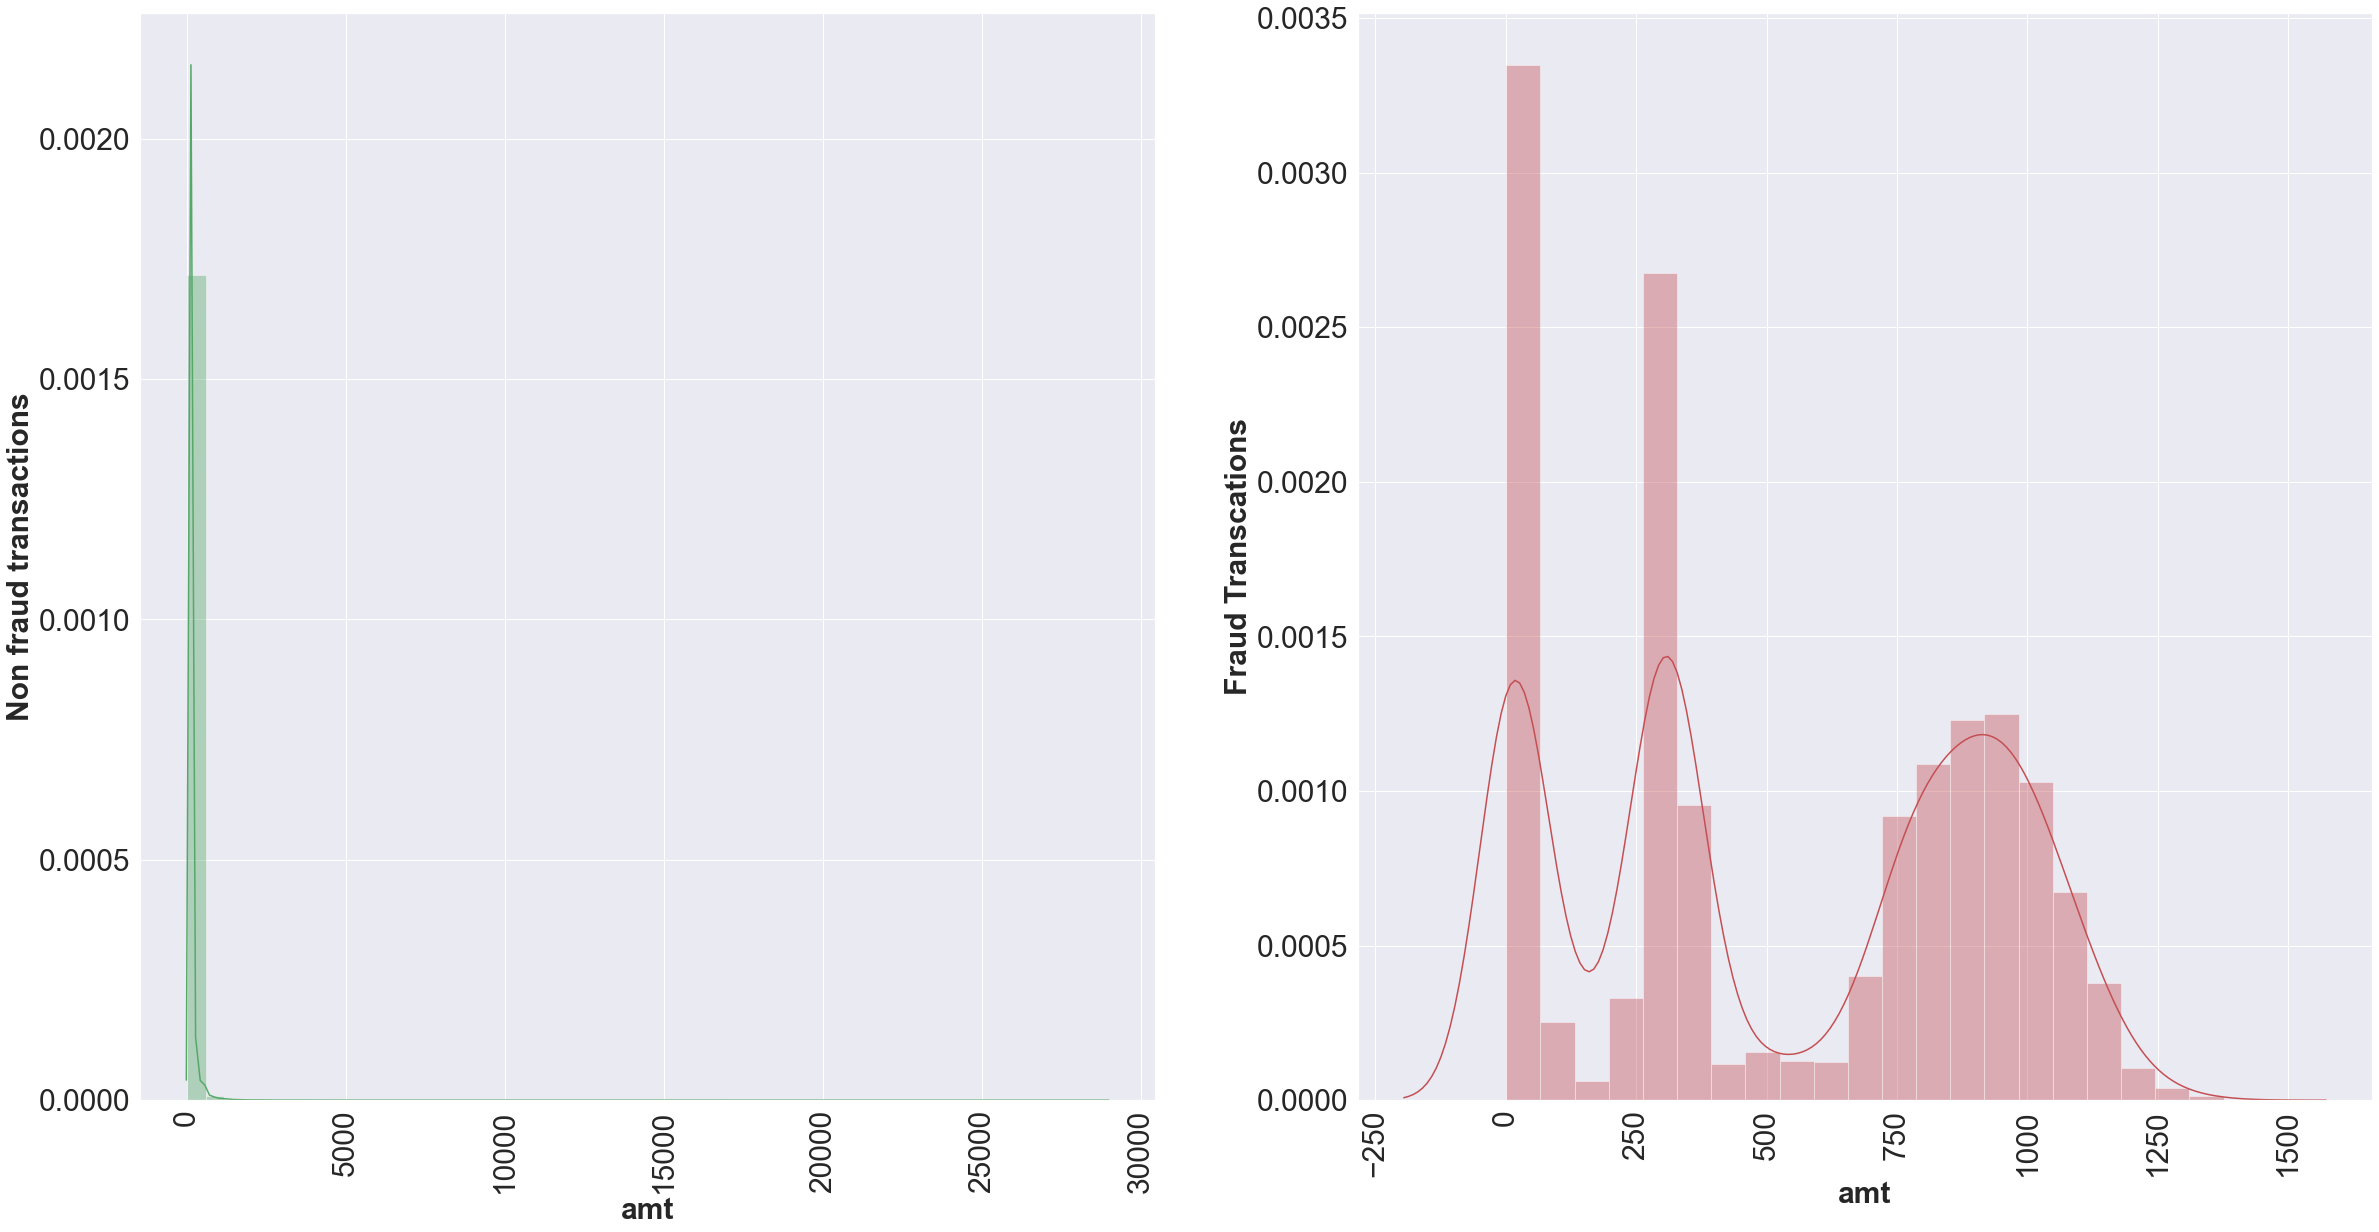

In [67]:
sns.set(style="darkgrid")
plt.figure(figsize=(40,20))
    
plt.subplot(1,2,1)                                   
sns.distplot(target0['amt'], color="g" )
plt.yscale('linear') 
plt.xlabel('amt', fontsize= 30, fontweight="bold")
plt.ylabel('Non fraud transactions', fontsize= 30, fontweight="bold")                    #Target 0
plt.xticks(rotation=90, fontsize=30)
plt.yticks(rotation=360, fontsize=30)
     
    
    
    
plt.subplot(1,2,2)                                                                                                      
sns.distplot(target1['amt'], color="r")
plt.yscale('linear')    
plt.xlabel('amt', fontsize= 30, fontweight="bold")
plt.ylabel('Fraud Transcations', fontsize= 30, fontweight="bold")                       # Target 1
plt.xticks(rotation=90, fontsize=30)
plt.yticks(rotation=360, fontsize=30)
    
plt.show();

In [99]:
target0['amt'].std()

154.00797054608165

In [100]:
target1['amt'].std()

390.56006972553587

In [101]:
target0['amt'].skew() #highle positive skewed  

47.523765335989694

# insight

Dist. plot highlights the curve shape which is wider for Target 1 in comparison to Target 0 which is narrower with well-defined edges.

In [23]:
df1['trans_date_trans_time']

0          2019-01-01 00:00:18
1          2019-01-01 00:00:44
2          2019-01-01 00:00:51
3          2019-01-01 00:01:16
4          2019-01-01 00:03:06
                  ...         
1296670    2020-06-21 12:12:08
1296671    2020-06-21 12:12:19
1296672    2020-06-21 12:12:32
1296673    2020-06-21 12:13:36
1296674    2020-06-21 12:13:37
Name: trans_date_trans_time, Length: 1296675, dtype: object

In [24]:
df1['trans_date_trans_time']=pd.to_datetime(df1['trans_date_trans_time'])

In [25]:
df['trans_date_trans_time']=pd.to_datetime(df['trans_date_trans_time'])

In [26]:
df1['weekday_no'] = df1['trans_date_trans_time'].dt.dayofweek
df1['week_day'] = df1['trans_date_trans_time'].dt.day_name()
df1['week_no'] = df1['trans_date_trans_time'].dt.week
df1['day_no'] = df1['trans_date_trans_time'].dt.day
df1['min_day'] = df1['trans_date_trans_time'].dt.minute
df1['hr_day'] = df1['trans_date_trans_time'].dt.hour
df1['month_name'] = df1['trans_date_trans_time'].dt.month_name()
df1['month'] = df1['trans_date_trans_time'].dt.month
df1['year'] = df1['trans_date_trans_time'].dt.year
df1['year_dayno'] = df1['trans_date_trans_time'].dt.dayofyear

<ipython-input-26-1c1eb304374b>:3: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [27]:
df['weekday_no'] = df['trans_date_trans_time'].dt.dayofweek
df['week_day'] = df['trans_date_trans_time'].dt.day_name()
df['week_no'] = df['trans_date_trans_time'].dt.week
df['day_no'] = df['trans_date_trans_time'].dt.day
df['min_day'] = df['trans_date_trans_time'].dt.minute
df['hr_day'] = df['trans_date_trans_time'].dt.hour
df['month_name'] = df['trans_date_trans_time'].dt.month_name()
df['month'] = df['trans_date_trans_time'].dt.month
df['year'] = df['trans_date_trans_time'].dt.year
df['year_dayno'] = df['trans_date_trans_time'].dt.dayofyear

<ipython-input-27-0b06bea21bae>:3: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [28]:
df.head(2)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,year,age_group,weekday_no,week_day,week_no,day_no,min_day,hr_day,month_name,month,year_dayno
0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0,2020,Senior citizen,6,Sunday,25,21,14,12,June,6,173
1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0,2020,Young age,6,Sunday,25,21,14,12,June,6,173


In [29]:
df1

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,year,age_group,weekday_no,week_day,week_no,day_no,min_day,hr_day,month_name,month,year_dayno
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,2019,Young age,1,Tuesday,1,1,0,0,January,1,1
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,2019,Middle age,1,Tuesday,1,1,0,0,January,1,1
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,2019,Senior citizen,1,Tuesday,1,1,0,0,January,1,1
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,2019,Senior citizen,1,Tuesday,1,1,1,0,January,1,1
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,2019,Middle age,1,Tuesday,1,1,3,0,January,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,2020-06-21 12:12:08,30263540414123,fraud_Reichel Inc,entertainment,15.56,Erik,Patterson,M,162 Jessica Row Apt. 072,Hatch,UT,84735,37.7175,-112.4777,258,Geoscientist,1961-11-24,440b587732da4dc1a6395aba5fb41669,1371816728,36.841266,-111.690765,0,2020,Senior citizen,6,Sunday,25,21,12,12,June,6,173
1296671,2020-06-21 12:12:19,6011149206456997,fraud_Abernathy and Sons,food_dining,51.70,Jeffrey,White,M,8617 Holmes Terrace Suite 651,Tuscarora,MD,21790,39.2667,-77.5101,100,"Production assistant, television",1979-12-11,278000d2e0d2277d1de2f890067dcc0a,1371816739,38.906881,-78.246528,0,2020,Middle age,6,Sunday,25,21,12,12,June,6,173
1296672,2020-06-21 12:12:32,3514865930894695,fraud_Stiedemann Ltd,food_dining,105.93,Christopher,Castaneda,M,1632 Cohen Drive Suite 639,High Rolls Mountain Park,NM,88325,32.9396,-105.8189,899,Naval architect,1967-08-30,483f52fe67fabef353d552c1e662974c,1371816752,33.619513,-105.130529,0,2020,Senior citizen,6,Sunday,25,21,12,12,June,6,173
1296673,2020-06-21 12:13:36,2720012583106919,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,Joseph,Murray,M,42933 Ryan Underpass,Manderson,SD,57756,43.3526,-102.5411,1126,Volunteer coordinator,1980-08-18,d667cdcbadaaed3da3f4020e83591c83,1371816816,42.788940,-103.241160,0,2020,Middle age,6,Sunday,25,21,13,12,June,6,173


In [106]:
df1['week_day'].value_counts()

Monday       254282
Sunday       250579
Saturday     200957
Tuesday      160227
Friday       152272
Thursday     147285
Wednesday    131073
Name: week_day, dtype: int64

In [107]:
df1['month_name'].value_counts().sort_values(ascending=False)

May          146875
June         143811
March        143789
December     141060
April        134970
January      104727
February      97657
August        87359
July          86596
September     70652
November      70421
October       68758
Name: month_name, dtype: int64

In [76]:
temp = df1["week_day"].value_counts().head(10)
df = pd.DataFrame({'Class': temp.index,'values': temp.values})

trace = go.Bar(
    x = df['Class'],y = df['values'],
    name=' week days vs  no of transactions',
    marker=dict(color="Red"),
    text=df['values']
)
data = [trace]
layout = dict(title ='week days vs no of transactions',
          xaxis = dict(title = 'weekdays', showticklabels=True), 
          yaxis = dict(title = 'Number of fraud transactions'),
          hovermode = 'closest',width=600
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='class')

In [77]:
temp = df1['month_name'].value_counts().sort_values(ascending=False)
df = pd.DataFrame({'Class': temp.index,'values': temp.values})

trace = go.Bar(
    x = df['Class'],y = df['values'],
    name=' month vs  no of transactions',
    marker=dict(color="Red"),
    text=df['values']
)
data = [trace]
layout = dict(title ='month vs no of transactions',
          xaxis = dict(title = '', showticklabels=True), 
          yaxis = dict(title = 'Number of fraud transactions'),
          hovermode = 'closest',width=600
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='class')

# Bivariate Analysis : Numerical and Categorical wrt target variables

In [110]:
df1

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,year,age_group,weekday_no,week_day,week_no,day_no,min_day,hr_day,month_name,month,year_dayno
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,2019,Young age,1,Tuesday,1,1,0,0,January,1,1
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,2019,Middle age,1,Tuesday,1,1,0,0,January,1,1
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,2019,Senior citizen,1,Tuesday,1,1,0,0,January,1,1
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,2019,Senior citizen,1,Tuesday,1,1,1,0,January,1,1
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,2019,Middle age,1,Tuesday,1,1,3,0,January,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,2020-06-21 12:12:08,30263540414123,fraud_Reichel Inc,entertainment,15.56,Erik,Patterson,M,162 Jessica Row Apt. 072,Hatch,UT,84735,37.7175,-112.4777,258,Geoscientist,1961-11-24,440b587732da4dc1a6395aba5fb41669,1371816728,36.841266,-111.690765,0,2020,Senior citizen,6,Sunday,25,21,12,12,June,6,173
1296671,2020-06-21 12:12:19,6011149206456997,fraud_Abernathy and Sons,food_dining,51.70,Jeffrey,White,M,8617 Holmes Terrace Suite 651,Tuscarora,MD,21790,39.2667,-77.5101,100,"Production assistant, television",1979-12-11,278000d2e0d2277d1de2f890067dcc0a,1371816739,38.906881,-78.246528,0,2020,Middle age,6,Sunday,25,21,12,12,June,6,173
1296672,2020-06-21 12:12:32,3514865930894695,fraud_Stiedemann Ltd,food_dining,105.93,Christopher,Castaneda,M,1632 Cohen Drive Suite 639,High Rolls Mountain Park,NM,88325,32.9396,-105.8189,899,Naval architect,1967-08-30,483f52fe67fabef353d552c1e662974c,1371816752,33.619513,-105.130529,0,2020,Senior citizen,6,Sunday,25,21,12,12,June,6,173
1296673,2020-06-21 12:13:36,2720012583106919,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,Joseph,Murray,M,42933 Ryan Underpass,Manderson,SD,57756,43.3526,-102.5411,1126,Volunteer coordinator,1980-08-18,d667cdcbadaaed3da3f4020e83591c83,1371816816,42.788940,-103.241160,0,2020,Middle age,6,Sunday,25,21,13,12,June,6,173


# merchant vs amount transaction vs target variable

In [78]:
df_merch_amt=df1.pivot_table(index='merchant',columns='is_fraud',values='amt',aggfunc='sum')

In [79]:
df_merch_amt.reset_index(inplace=True)

In [80]:
df_merch_amt.rename(columns={0:'not_fraud',1:'fraud'},inplace=True)

In [81]:
df_merch_amt=df_merch_amt.head(10)

In [82]:
df_merch_amt

is_fraud,merchant,not_fraud,fraud
0,fraud_Abbott-Rogahn,115140.81,1517.73
1,fraud_Abbott-Steuber,88675.06,151.94
2,fraud_Abernathy and Sons,90098.54,481.68
3,fraud_Abshire PLC,122530.89,4602.36
4,"fraud_Adams, Kovacek and Kuhlman",50159.25,59.52
5,fraud_Adams-Barrows,92190.84,26.14
6,"fraud_Altenwerth, Cartwright and Koss",124709.68,26780.13
7,fraud_Altenwerth-Kilback,144222.73,2033.38
8,fraud_Ankunding LLC,131176.73,30384.14
9,fraud_Ankunding-Carroll,90809.93,23.34


In [83]:
from plotly.subplots import make_subplots 
import plotly.graph_objects as go


fig = make_subplots(rows=1, cols=2, shared_yaxes=True,subplot_titles=('merchant non-fraud transaction amount',"merchant fraud transaction amount"))

fig.add_trace(go.Bar(x=df_merch_amt['merchant'], y=df_merch_amt['not_fraud'],
                    marker=dict(color=df_merch_amt['not_fraud'], coloraxis="coloraxis")),
              1, 1)

fig.add_trace(go.Bar(x=df_merch_amt['merchant'], y=df_merch_amt['fraud'],
                    marker=dict( color=df_merch_amt['fraud'],coloraxis="coloraxis")),
              1, 2)

fig['layout']['xaxis']['title']='merchant'
fig['layout']['xaxis2']['title']='merchant'
fig['layout']['yaxis']['title']='not fraud transaction amount'
fig['layout']['yaxis2']['title']='fraud transaction amount'

fig.update_layout(coloraxis=dict(colorscale='Bluered_r'), showlegend=False)
fig.show()

# job vs amount transaction vs target variable

In [84]:
df_job_amt=df1.pivot_table(index='job',columns='is_fraud',values='amt',aggfunc='sum')
df_job_amt.reset_index(inplace=True)
df_job_amt.rename(columns={0:'not_fraud',1:'fraud'},inplace=True)
df_job_amt=df_job_amt.sort_values('fraud',ascending=False).head(10)
df_job_amt

is_fraud,job,not_fraud,fraud
286,Materials engineer,426577.36,34787.71
308,Naval architect,602173.44,34638.89
42,Audiological scientist,395635.90,30374.34
381,Quantity surveyor,338541.11,28404.20
419,Senior tax professional/tax inspector,243592.24,28331.54
477,Trading standards officer,362798.51,26775.68
187,Exhibition designer,625789.30,26727.43
287,Mechanical engineer,382427.98,26047.70
193,Film/video editor,729757.25,25719.78
459,Television production assistant,310368.83,25689.57


In [85]:
from plotly.subplots import make_subplots 
import plotly.graph_objects as go


fig = make_subplots(rows=1, cols=2, shared_yaxes=True,subplot_titles=('job non-fraud transaction amount',"job fraud transaction amount"))

fig.add_trace(go.Bar(x=df_job_amt['job'], y=df_job_amt['not_fraud'],
                    marker=dict(color=df_job_amt['not_fraud'], coloraxis="coloraxis")),
              1, 1)

fig.add_trace(go.Bar(x=df_job_amt['job'], y=df_job_amt['fraud'],
                    marker=dict( color=df_job_amt['fraud'],coloraxis="coloraxis")),
              1, 2)

fig['layout']['xaxis']['title']='jobs'
fig['layout']['xaxis2']['title']='jobs'
fig['layout']['yaxis']['title']='not fraud transaction amount'
fig['layout']['yaxis2']['title']='fraud transaction amount'

fig.update_layout(coloraxis=dict(colorscale='Bluered_r'), showlegend=False)
fig.show()

# month vs amount transaction vs target variable

In [119]:
df1['month_name'].value_counts()

May          146875
June         143811
March        143789
December     141060
April        134970
January      104727
February      97657
August        87359
July          86596
September     70652
November      70421
October       68758
Name: month_name, dtype: int64

In [86]:
df_month_amt=df1.pivot_table(index='month_name',columns='is_fraud',values='amt',aggfunc='sum')
df_month_amt.reset_index(inplace=True)
df_month_amt.rename(columns={0:'not_fraud',1:'fraud'},inplace=True)
df_month_amt=df_month_amt.head(12)
df_month_amt

is_fraud,month_name,not_fraud,fraud
0,April,9098593.09,354241.27
1,August,5843337.52,203951.13
2,December,9583021.64,335157.54
3,February,6516605.09,458001.19
4,January,6978438.78,444375.74
5,July,5855325.15,188701.59
6,June,9784947.76,358434.41
7,March,9718274.79,471727.69
8,May,9807164.65,497775.49
9,November,4722945.12,200307.47


In [87]:
from plotly.subplots import make_subplots 
import plotly.graph_objects as go


fig = make_subplots(rows=1, cols=2, shared_yaxes=True,subplot_titles=('month wise non-fraud transaction amount',"month wise fraud transaction amount"))

fig.add_trace(go.Bar(x=df_month_amt['month_name'], y=df_month_amt['not_fraud'],
                    marker=dict(color=df_month_amt['not_fraud'], coloraxis="coloraxis")),
              1, 1)

fig.add_trace(go.Bar(x=df_month_amt['month_name'], y=df_month_amt['fraud'],
                    marker=dict( color=df_month_amt['fraud'],coloraxis="coloraxis")),
              1, 2)

fig['layout']['xaxis']['title']='months'
fig['layout']['xaxis2']['title']='months'
fig['layout']['yaxis']['title']='not fraud transaction amount'
fig['layout']['yaxis2']['title']='fraud transaction amount'

fig.update_layout(coloraxis=dict(colorscale='Bluered_r'), showlegend=False)
fig.show()

# Merchant Category vs amt transaction vs target variable 

In [88]:
df_mercat_amt=df1.pivot_table(index='category',columns='is_fraud',values='amt',aggfunc='sum')
df_mercat_amt.reset_index(inplace=True)
df_mercat_amt.rename(columns={0:'not_fraud',1:'fraud'},inplace=True)
df_mercat_amt=df_mercat_amt.sort_values('fraud',ascending=False).head(10)
df_mercat_amt

is_fraud,category,not_fraud,fraud
11,shopping_net,6913425.97,1711723.71
12,shopping_pos,8568748.52,739245.09
8,misc_net,4388442.50,729266.76
4,grocery_pos,13917024.48,543797.90
0,entertainment,5919354.77,117323.79
9,misc_pos,4955011.48,54571.02
6,home,7122956.45,50971.66
1,food_dining,4654327.82,18131.62
2,gas_transport,8344138.18,7594.11
10,personal_care,4347693.01,5757.52


In [89]:
from plotly.subplots import make_subplots 
import plotly.graph_objects as go


fig = make_subplots(rows=1, cols=2, shared_yaxes=True,subplot_titles=('merchant category wise non-fraud transaction amount',"merchant category wise fraud transaction amount"))

fig.add_trace(go.Bar(x=df_mercat_amt['category'], y=df_mercat_amt['not_fraud'],
                    marker=dict(color=df_mercat_amt['not_fraud'], coloraxis="coloraxis")),
              1, 1)

fig.add_trace(go.Bar(x=df_mercat_amt['category'], y=df_mercat_amt['fraud'],
                    marker=dict( color=df_mercat_amt['fraud'],coloraxis="coloraxis")),
              1, 2)

fig['layout']['xaxis']['title']='merchant category'
fig['layout']['xaxis2']['title']='merchant category'
fig['layout']['yaxis']['title']='not fraud transaction amount'
fig['layout']['yaxis2']['title']='fraud transaction amount'

fig.update_layout(coloraxis=dict(colorscale='viridis'), showlegend=False)
fig.show()

# state vs amt transaction vs target variable 

In [90]:
df_state_amt=df1.pivot_table(index='state',columns='is_fraud',values='amt',aggfunc='sum')
df_state_amt.reset_index(inplace=True)
df_state_amt.rename(columns={0:'not_fraud',1:'fraud'},inplace=True)
df_state_amt=df_state_amt.sort_values('fraud',ascending=False).head(10)
df_state_amt

is_fraud,state,not_fraud,fraud
34,NY,5710950.39,295548.64
43,TX,6535111.12,265806.41
38,PA,5526384.86,244624.67
4,CA,3967134.59,170943.92
35,OH,3227226.68,168919.98
9,FL,3004278.60,150913.03
14,IL,2883449.31,128441.99
22,MI,3161712.88,121012.08
1,AL,2570120.11,112596.99
23,MN,2089331.68,112454.39


In [91]:
from plotly.subplots import make_subplots 
import plotly.graph_objects as go


fig = make_subplots(rows=1, cols=2, shared_yaxes=True,subplot_titles=('State wise non-fraud transaction amount',"State wise fraud transaction amount"))

fig.add_trace(go.Bar(x=df_state_amt['state'], y=df_state_amt['not_fraud'],
                    marker=dict(color=df_state_amt['not_fraud'], coloraxis="coloraxis")),
              1, 1)

fig.add_trace(go.Bar(x=df_state_amt['state'], y=df_state_amt['fraud'],
                    marker=dict( color=df_state_amt['fraud'],coloraxis="coloraxis")),
              1, 2)

fig['layout']['xaxis']['title']='State'
fig['layout']['xaxis2']['title']='State'
fig['layout']['yaxis']['title']='not fraud transaction amount'
fig['layout']['yaxis2']['title']='fraud transaction amount'

fig.update_layout(coloraxis=dict(colorscale='thermal'), showlegend=False)
fig.show()

# city vs amt transaction vs target variable 

In [92]:
df_city_amt=df1.pivot_table(index='city',columns='is_fraud',values='amt',aggfunc='sum')
df_city_amt.reset_index(inplace=True)
df_city_amt.rename(columns={0:'not_fraud',1:'fraud'},inplace=True)
df_city_amt=df_city_amt.sort_values('fraud',ascending=False).head(10)
df_city_amt

is_fraud,city,not_fraud,fraud
359,Houston,353598.28,21667.21
193,Dallas,269662.76,19747.14
837,Warren,266014.77,18221.79
810,Tulsa,224467.60,17470.25
554,Naples,248260.26,17220.43
368,Huntsville,214348.80,15142.79
676,Randolph,87233.25,14773.45
725,San Antonio,308455.61,14536.75
424,Lakeland,295218.46,13211.61
564,New York City,193826.13,13136.86


In [93]:
from plotly.subplots import make_subplots 
import plotly.graph_objects as go


fig = make_subplots(rows=1, cols=2, shared_yaxes=True,subplot_titles=('city wise non-fraud transaction amount',"city wise fraud transaction amount"))

fig.add_trace(go.Bar(x=df_city_amt['city'], y=df_city_amt['not_fraud'],
                    marker=dict(color=df_city_amt['not_fraud'], coloraxis="coloraxis")),
              1, 1)

fig.add_trace(go.Bar(x=df_city_amt['city'], y=df_city_amt['fraud'],
                    marker=dict( color=df_city_amt['fraud'],coloraxis="coloraxis")),
              1, 2)

fig['layout']['xaxis']['title']='city'
fig['layout']['xaxis2']['title']='city'
fig['layout']['yaxis']['title']='not fraud transaction amount'
fig['layout']['yaxis2']['title']='fraud transaction amount'

fig.update_layout(coloraxis=dict(colorscale='plasma'), showlegend=False)
fig.show()

# Gender vs amt transaction amount vs target variable

In [94]:
df_gender_amt=df1.pivot_table(index='gender',columns='is_fraud',values='amt',aggfunc='sum')
df_gender_amt.reset_index(inplace=True)
df_gender_amt.rename(columns={0:'not_fraud',1:'fraud'},inplace=True)
df_gender_amt=df_gender_amt.sort_values('fraud',ascending=False).head(10)
df_gender_amt

is_fraud,gender,not_fraud,fraud
1,M,3.924701e+07,2142801.27
0,F,4.798733e+07,1845287.34


In [95]:
from plotly.subplots import make_subplots 
import plotly.graph_objects as go


fig = make_subplots(rows=1, cols=2, shared_yaxes=True,subplot_titles=('gender wise non-fraud transaction amount',"gender wise fraud transaction amount"))

fig.add_trace(go.Bar(x=df_gender_amt['gender'], y=df_gender_amt['not_fraud'],
                    marker=dict(color=df_gender_amt['not_fraud'], coloraxis="coloraxis")),
              1, 1)

fig.add_trace(go.Bar(x=df_gender_amt['gender'], y=df_gender_amt['fraud'],
                    marker=dict( color=df_gender_amt['fraud'],coloraxis="coloraxis")),
              1, 2)

fig['layout']['xaxis']['title']='gender'
fig['layout']['xaxis2']['title']='gender'
fig['layout']['yaxis']['title']='not fraud transaction amount'
fig['layout']['yaxis2']['title']='fraud transaction amount'

fig.update_layout(coloraxis=dict(colorscale='jet'), showlegend=False)
fig.show()

# month vs amount vs target variable trend graph

In [130]:
df1.head(2)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,year,age_group,weekday_no,week_day,week_no,day_no,min_day,hr_day,month_name,month,year_dayno
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,2019,Young age,1,Tuesday,1,1,0,0,January,1,1
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,2019,Middle age,1,Tuesday,1,1,0,0,January,1,1


<AxesSubplot:xlabel='year,month_name'>

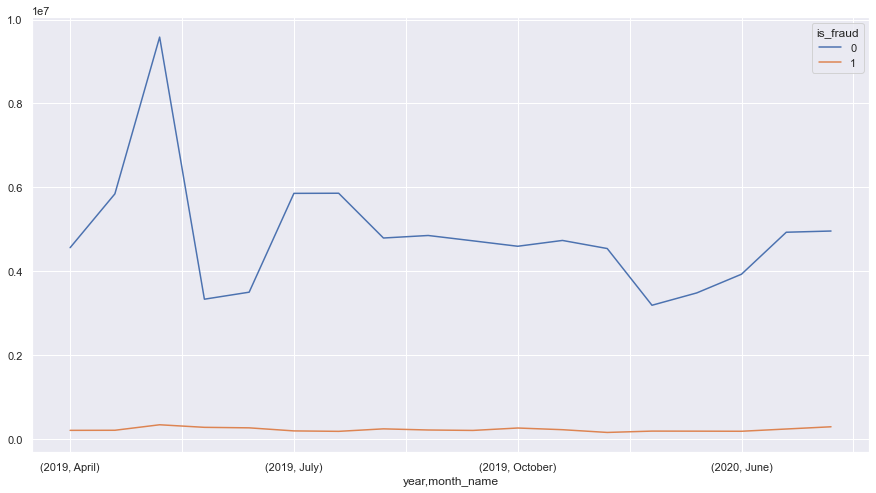

In [131]:
df1.pivot_table(index=['year','month_name'],columns=['is_fraud'],values='amt',aggfunc='sum').plot(kind='line')

In [96]:
df_trend=df1.pivot_table(index=['year','month_name','month'],columns=['is_fraud'],values='amt',aggfunc='sum')

In [97]:
df_trend.reset_index(inplace=True)

In [98]:
df_trend.rename(columns={0:'not_fraud transaction amount',1:'fraud transaction amount'},inplace=True)

In [99]:
df_trend

is_fraud,year,month_name,month,not_fraud transaction amount,fraud transaction amount
0,2019,April,4,4559437.29,202067.29
1,2019,August,8,5843337.52,203951.13
2,2019,December,12,9583021.64,335157.54
3,2019,February,2,3330611.15,274051.08
4,2019,January,1,3497969.65,261780.38
5,2019,July,7,5855325.15,188701.59
6,2019,June,6,5858192.82,178204.60
7,2019,March,3,4790248.81,237637.59
8,2019,May,5,4850354.21,210549.11
9,2019,November,11,4722945.12,200307.47


In [100]:
df_trend=df_trend.sort_values('month')


In [101]:
import plotly.express as px

df = px.data.gapminder().query("continent=='Oceania'")
fig = px.line(df_trend, x="month_name", y='fraud transaction amount', color='year')

fig.show()

# insight 
 from the dataset ,
 2019 fraud transaction amount got its peak during december month and least at june month
 2020 fraud transaction amount got its peak during may month and least during the april month  


# statistical Significance

In [138]:
df1.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,year,age_group,weekday_no,week_day,week_no,day_no,min_day,hr_day,month_name,month,year_dayno
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,2019,Young age,1,Tuesday,1,1,0,0,January,1,1
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,2019,Middle age,1,Tuesday,1,1,0,0,January,1,1
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,2019,Senior citizen,1,Tuesday,1,1,0,0,January,1,1
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,2019,Senior citizen,1,Tuesday,1,1,1,0,January,1,1
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,2019,Middle age,1,Tuesday,1,1,3,0,January,1,1


# dropping few columns which will not help in analysis

# for categorical columns with sub category more than 2 and categorical variable equal to 2 we use chi square test

In [30]:
df2=df1.drop(['trans_date_trans_time','cc_num','first','last','street','zip','dob','trans_num','unix_time','week_day','month_name'],axis=1)

In [31]:
df2.shape

(1296675, 22)

In [141]:
df2.head()

,merchant,category,amt,gender,city,state,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,year,age_group,weekday_no,week_no,day_no,min_day,hr_day,month,year_dayno
0,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,Moravian Falls,NC,36.0788,-81.1781,3495,"Psychologist, counselling",36.011293,-82.048315,0,2019,Young age,1,1,1,0,0,1,1
1,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,Orient,WA,48.8878,-118.2105,149,Special educational needs teacher,49.159047,-118.186462,0,2019,Middle age,1,1,1,0,0,1,1
2,fraud_Lind-Buckridge,entertainment,220.11,M,Malad City,ID,42.1808,-112.2620,4154,Nature conservation officer,43.150704,-112.154481,0,2019,Senior citizen,1,1,1,0,0,1,1
3,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,Boulder,MT,46.2306,-112.1138,1939,Patent attorney,47.034331,-112.561071,0,2019,Senior citizen,1,1,1,1,0,1,1
4,fraud_Keeling-Crist,misc_pos,41.96,M,Doe Hill,VA,38.4207,-79.4629,99,Dance movement psychotherapist,38.674999,-78.632459,0,2019,Middle age,1,1,1,3,0,1,1


#our target variable is is_fraud categorical variable

In [142]:
categorical columns
1.merchant
2.category
3.gender
4.city
5.state
6.job
7.year
8.age_group
9.weekday_no
10.week_no
11.day no
12.month

SyntaxError: invalid syntax (<ipython-input-142-4d40ff15276a>, line 1)

In [104]:
from scipy import stats

# merchant vs is_fraud

In [ ]:
#null: merchant and is_fraud are independent
#alter:merchant and is_fraud are dependent

In [144]:
stats.chi2_contingency(pd.crosstab(df2['merchant'],df2['is_fraud']))

(6929.5860791537525,
 0.0,
 692,
 array([[1833.32572618,   10.67427382],
        [1752.79460698,   10.20539302],
        [1740.8640708 ,   10.1359292 ],
        ...,
        [1685.18823529,    9.81176471],
        [2545.18105154,   14.81894846],
        [1772.67883394,   10.32116606]]))

#pvalue is less than significance level we reject null hypothesis
concluding that merchant and is_fraud are dependent

# category vs is_fraud

In [ ]:
#null: category and is_fraud are independent
#alter:category and is_fraud are dependent

In [145]:
stats.chi2_contingency(pd.crosstab(df2['category'],df2['is_fraud']))

(6486.003269983207,
 0.0,
 13,
 array([[ 93469.78569495,    544.21430505],
        [ 90931.56412285,    529.43587715],
        [130896.87190005,    762.12809995],
        [ 45188.89420094,    263.10579906],
        [122922.30267569,    715.69732431],
        [ 85381.87637689,    497.12362311],
        [122402.33014055,    712.66985945],
        [112380.67975013,    654.32024987],
        [ 62920.65359708,    366.34640292],
        [ 79193.90494534,    461.09505466],
        [ 90232.63354503,    525.36645497],
        [ 96978.35754295,    564.64245705],
        [115996.62642374,    675.37357626],
        [ 40272.51908381,    234.48091619]]))

In [ ]:
#pvalue is less than significance level we reject null hypothesis
concluding that category and is_fraud are dependent

# Gender vs is_fraud

In [ ]:
#null: gender and is_fraud are independent
#alter:gender and is_fraud are dependent

In [146]:
stats.chi2_contingency(pd.crosstab(df2['gender'],df2['is_fraud']))

(75.51456622055794,
 3.627211385830374e-18,
 1,
 array([[705753.85030713,   4109.14969287],
        [583415.14969287,   3396.85030713]]))

In [ ]:
#pvalue is less than significance level we reject null hypothesis
concluding that gender and is_fraud are dependent

# city vs is_fraud

In [ ]:
#null: gender and is_fraud are independent
#alter:gender and is_fraud are dependent

In [147]:
stats.chi2_contingency(pd.crosstab(df2['city'],df2['is_fraud']))

(104775.99647480424,
 0.0,
 893,
 array([[ 528.92043727,    3.07956273],
        [2084.86119729,   12.13880271],
        [ 513.0130557 ,    2.9869443 ],
        ...,
        [ 521.96095783,    3.03904217],
        [1547.98706923,    9.01293077],
        [1528.10284227,    8.89715773]]))

In [ ]:
#pvalue is less than significance level we reject null hypothesis
concluding that city and is_fraud are dependent

# state vs is_fraud

In [ ]:
#null: state and is_fraud are independent
#alter:state and is_fraud are dependent

In [148]:
stats.chi2_contingency(pd.crosstab(df2['state'],df2['is_fraud']))

(1869.3403883785622,
 0.0,
 50,
 array([[2.10772806e+03, 1.22719417e+01],
        [4.07517290e+04, 2.37271046e+02],
        [3.09468166e+04, 1.80183363e+02],
        [1.07076562e+04, 6.23437793e+01],
        [5.60337516e+04, 3.26248412e+02],
        [1.37996535e+04, 8.03464862e+01],
        [7.65741580e+03, 4.45841957e+01],
        [3.59208560e+03, 2.09143988e+01],
        [8.94790213e+00, 5.20978657e-02],
        [4.24239924e+04, 2.47007559e+02],
        [2.59121304e+04, 1.50869630e+02],
        [2.54418684e+03, 1.48131598e+01],
        [2.68287932e+04, 1.56206767e+02],
        [5.51290193e+03, 3.20980739e+01],
        [4.30016292e+04, 2.50370765e+02],
        [2.74203490e+04, 1.59651015e+02],
        [2.28628842e+04, 1.33115836e+02],
        [2.83101681e+04, 1.64831858e+02],
        [2.08436409e+04, 1.21359084e+02],
        [1.23043596e+04, 7.16403540e+01],
        [2.60413778e+04, 1.51622155e+02],
        [1.64094583e+04, 9.55416970e+01],
        [4.58868306e+04, 2.67169433e+02],
  

In [ ]:
#pvalue is less than significance level we reject null hypothesis
concluding that state and is_fraud are dependent

# job vs is_fraud

In [149]:
#null: job and is_fraud are independent
#alter:job and is_fraud are dependent
stats.chi2_contingency(pd.crosstab(df2['job'],df2['is_fraud']))

(39165.61850811396,
 0.0,
 493,
 array([[1.03497401e+03, 6.02598647e+00],
        [1.09363248e+01, 6.36751692e-02],
        [5.30908860e+02, 3.09114003e+00],
        [2.56506528e+03, 1.49347215e+01],
        [4.64594963e+03, 2.70503696e+01],
        [1.56787130e+03, 9.12870380e+00],
        [3.58313770e+03, 2.08623009e+01],
        [5.31903071e+02, 3.09692868e+00],
        [2.50938944e+03, 1.46105570e+01],
        [2.55611738e+03, 1.48826236e+01],
        [2.58992056e+03, 1.50794378e+01],
        [1.56389445e+03, 9.10554919e+00],
        [4.14287869e+03, 2.41213118e+01],
        [1.02503190e+03, 5.96809995e+00],
        [2.56407107e+03, 1.49289328e+01],
        [1.51716652e+03, 8.83348256e+00],
        [6.60355178e+03, 3.84482249e+01],
        [2.00433008e+03, 1.16699219e+01],
        [1.03000296e+03, 5.99704321e+00],
        [5.15001478e+02, 2.99852160e+00],
        [1.69015929e+01, 9.84070796e-02],
        [2.07889593e+03, 1.21040708e+01],
        [1.05187561e+03, 6.12439355e+00],
  

In [ ]:
#pvalue is less than significance level we reject null hypothesis
concluding that job and is_fraud are dependent

# year vs is_fraud

In [150]:
#null: yEAR and is_fraud are independent
#alter:year and is_fraud are dependent
stats.chi2_contingency(pd.crosstab(df2['year'],df2['is_fraud']))

(11.613062441739803,
 0.0006549022776507619,
 1,
 array([[919496.36543467,   5353.63456533],
        [369672.63456533,   2152.36543467]]))

In [ ]:
#pvalue is less than significance level we reject null hypothesis
concluding that year and is_fraud are dependent

# age_group vs is_fraud

In [151]:
#null: age_group and is_fraud are independent
#alter:age_group and is_fraud are dependent
stats.chi2_contingency(pd.crosstab(df2['age_group'],df2['is_fraud']))

(191.1925641698597,
 3.372808668682701e-41,
 3,
 array([[2.74147814e+05, 1.59618599e+03],
        [6.86207655e+05, 3.99534480e+03],
        [8.97971690e+04, 5.22831026e+02],
        [2.39016362e+05, 1.39163819e+03]]))

In [ ]:
#pvalue is less than significance level we reject null hypothesis
concluding that age_group and is_fraud are dependent

# weekday_no vs is_fraud

In [152]:
#null:weekday_no and is_fraud are independent
#alter:weekday_no and is_fraud are dependent
stats.chi2_contingency(pd.crosstab(df2['weekday_no'],df2['is_fraud']))


(185.5129009101617,
 2.2877424359174457e-37,
 6,
 array([[252810.05005726,   1471.94994274],
        [159299.50169703,    927.49830297],
        [130314.26404997,    758.73595003],
        [146432.4184279 ,    852.5815721 ],
        [151390.55042166,    881.44957834],
        [199793.7299115 ,   1163.2700885 ],
        [249128.48543467,   1450.51456533]]))

In [ ]:
#pvalue is less than significance level we reject null hypothesis
concluding that weekday_no and is_fraud are dependent

# week_no vs is_fraud

In [153]:
#null:week_no and is_fraud are independent
#alter:week_no and is_fraud are dependent
stats.chi2_contingency(pd.crosstab(df2['week_no'],df2['is_fraud']))

(921.768272599126,
 4.2926332205158226e-160,
 51,
 array([[27029.62392504,   157.37607496],
        [23932.65557522,   139.34442478],
        [23968.44718376,   139.55281624],
        [23607.54846434,   137.45153566],
        [23887.91606455,   139.08393545],
        [23696.03327434,   137.96672566],
        [23764.63385737,   138.36614263],
        [23873.00289433,   138.99710567],
        [26623.98569495,   155.01430505],
        [31658.67196252,   184.32803748],
        [31490.65024466,   183.34975534],
        [31828.68210307,   185.31789693],
        [31475.73707444,   183.26292556],
        [31689.49251432,   184.50748568],
        [31592.05980219,   183.94019781],
        [31649.72406039,   184.27593961],
        [31377.31015096,   182.68984904],
        [31290.81376366,   182.18623634],
        [31582.1176887 ,   183.8823113 ],
        [31429.00914107,   182.99085893],
        [33895.6474961 ,   197.3525039 ],
        [39236.55085893,   228.44914107],
        [39279.3019469 ,  

In [ ]:
#pvalue is less than significance level we reject null hypothesis
concluding that week_no and is_fraud are dependent

# day_no vs is_fraud

In [154]:
#null:day_no and is_fraud are independent
#alter:day_no and is_fraud are dependent
stats.chi2_contingency(pd.crosstab(df2['day_no'],df2['is_fraud']))

(270.04783357773016,
 1.960340429340447e-40,
 30,
 array([[46816.41817803,   272.58182197],
        [44488.96941176,   259.03058824],
        [41599.79123373,   242.20876627],
        [41238.89251432,   240.10748568],
        [41643.53653306,   242.46346694],
        [41180.23404477,   239.76595523],
        [43982.9158355 ,   256.0841645 ],
        [45933.55850078,   267.44149922],
        [44426.33409682,   258.66590318],
        [41691.25867777,   242.74132223],
        [41183.21667881,   239.78332119],
        [41757.87083811,   243.12916189],
        [40858.10956793,   237.89043207],
        [43760.21249349,   254.78750651],
        [45945.48903696,   267.51096304],
        [44634.12426861,   259.87573139],
        [42027.30211348,   244.69788652],
        [40624.46990109,   236.53009891],
        [41225.96776679,   240.03223321],
        [40949.57701197,   238.42298803],
        [41687.28183238,   242.71816762],
        [41817.523519  ,   243.476481  ],
        [40578.73617907,  

In [ ]:
#pvalue is less than significance level we reject null hypothesis
concluding that day_no and is_fraud are dependent

# month vs is_fraud

In [155]:
#null:month  and is_fraud are independent
#alter:month  and is_fraud are dependent
stats.chi2_contingency(pd.crosstab(df2['month'],df2['is_fraud']))

(465.7946230638063,
 6.248884233368419e-93,
 11,
 array([[104120.77186882,    606.22813118],
        [ 97091.69763665,    565.30236335],
        [142956.6555544 ,    832.3444456 ],
        [134188.70567413,    781.29432587],
        [146024.79177512,    850.20822488],
        [142978.52820406,    832.47179594],
        [ 86094.72591359,    501.27408641],
        [ 86853.30917231,    505.69082769],
        [ 70243.02017699,    408.97982301],
        [ 68359.98388339,    398.01611661],
        [ 70013.35735554,    407.64264446],
        [140243.45278501,    816.54721499]]))

In [ ]:
#pvalue is less than significance level we reject null hypothesis
concluding that month and is_fraud are dependent

In [ ]:
numerical columns
1.amt
2.lat
3.long
4.merch_lat
5.merch_long
6.city_pop
7.year_dayno
8.min_day
9.hr_day

# feature Engineering

# 1.-	Whether any transformations required

In [ ]:
#yoe johnson transformations required for our dataset to reduce our skewness

# 2.dropping the redundant columns 

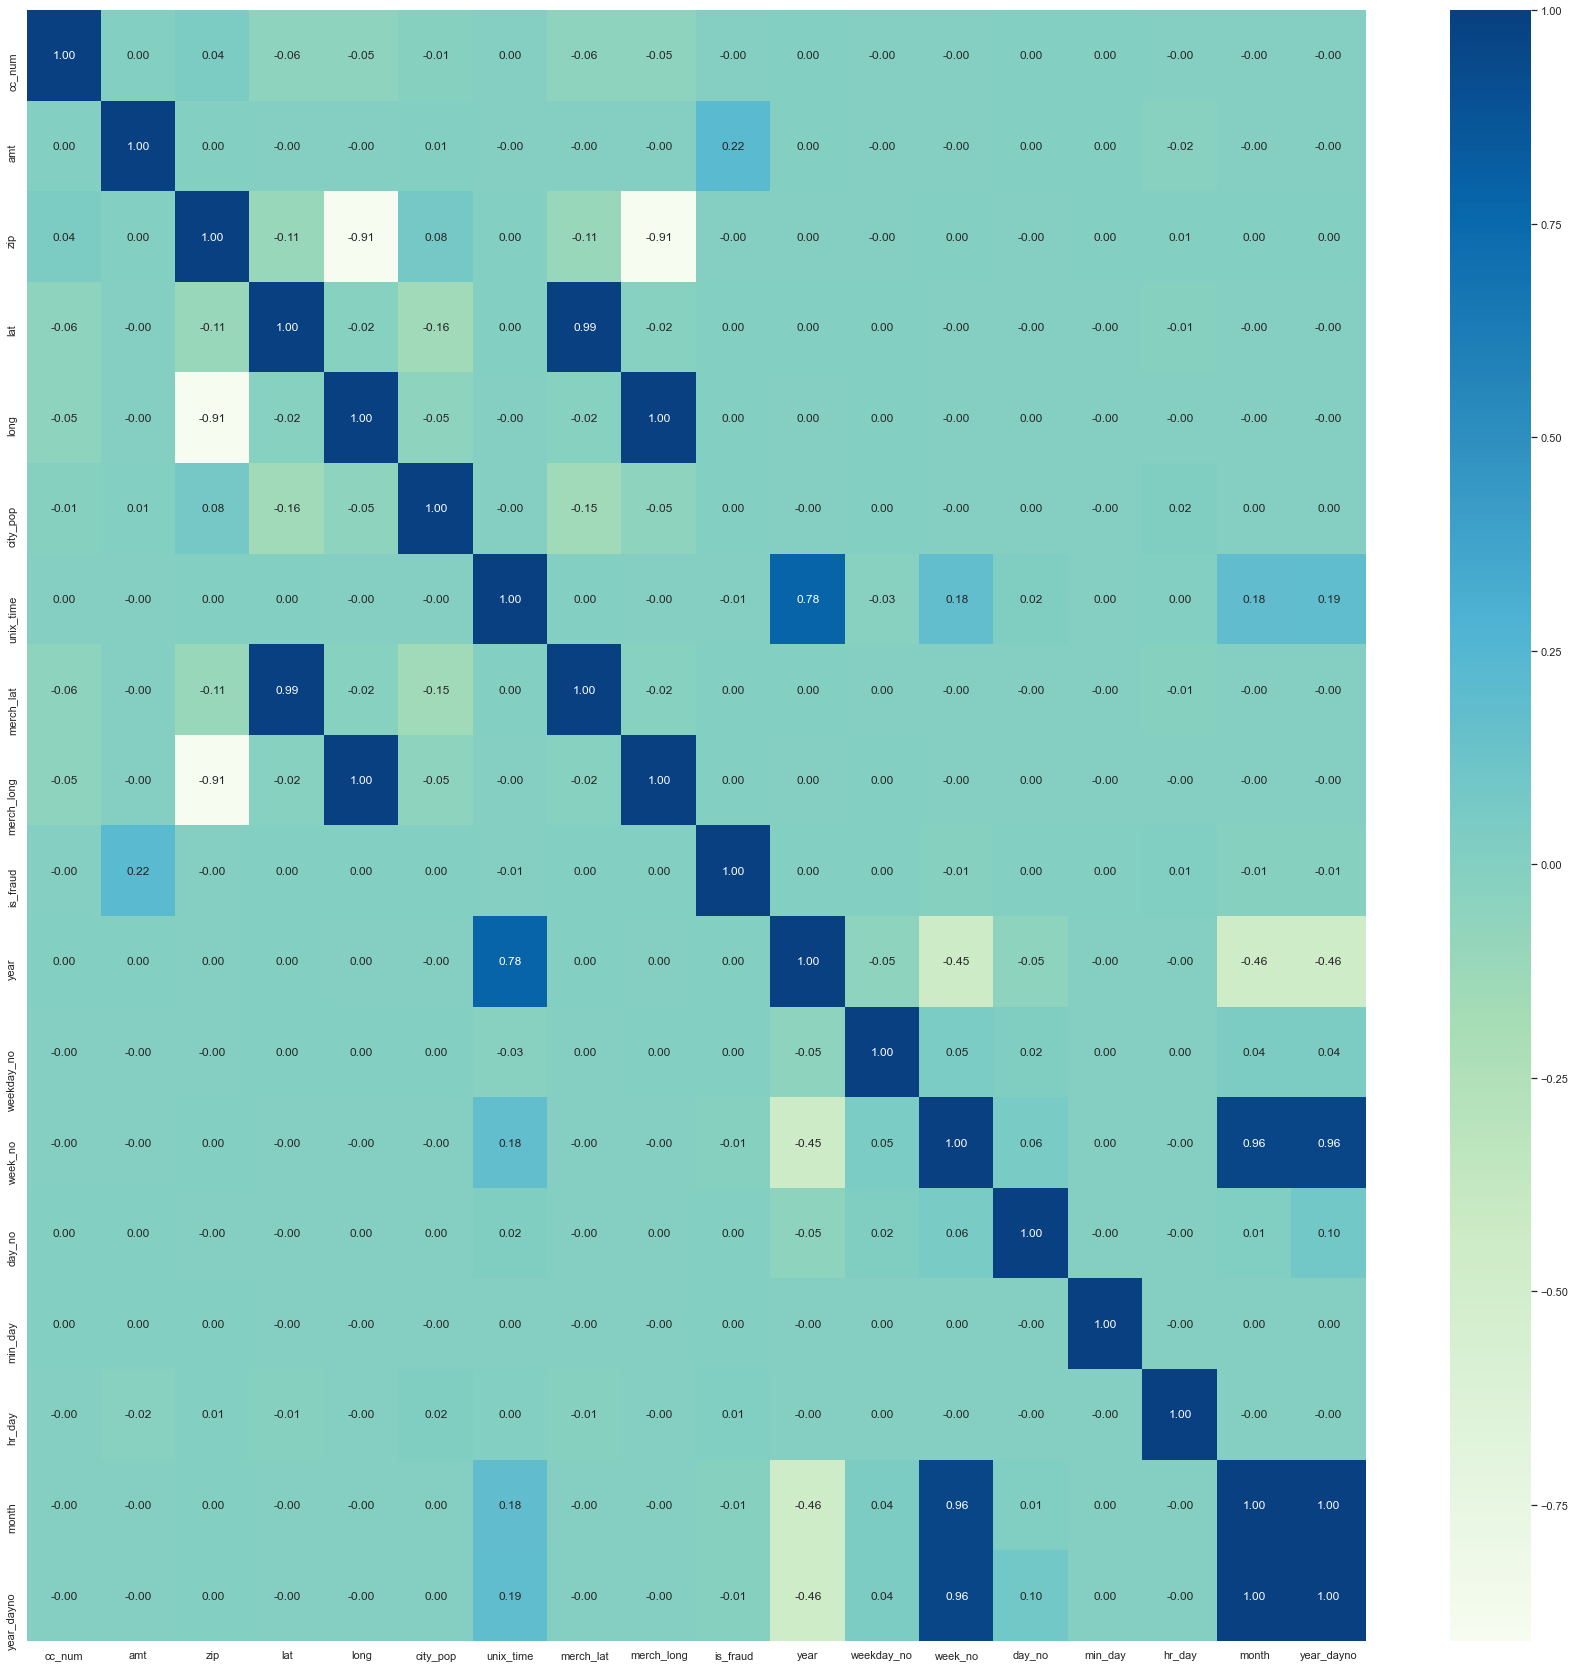

In [156]:
plt.figure(figsize = (30,30))
sns.heatmap(df1.corr(),annot = True, cmap="GnBu",fmt='.2f')
plt.show()

from correlation matrix we can see columns with 
high multi collinearity is marked with dark blue we can drop either one column based on vif score

In [ ]:
1.zip
2.lat
3.long
4.unix time
5.month 
6.year_dayno
7.week_no

In [32]:
df1_no=df1.select_dtypes(include=[np.number])

In [106]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X=df1_no
vif = pd.DataFrame()
vif["VIF_Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Features"] = X.columns
print(vif)

    VIF_Factor    Features
0     1.007083      cc_num
1     1.000019         amt
2     1.007735         zip
3     1.033511         lat
4     5.743480        long
5     1.006340    city_pop
6     0.000397   unix_time
7     1.033083   merch_lat
8     5.695472  merch_long
9     1.000002    is_fraud
10    0.000575        year
11    0.999058  weekday_no
12    1.005454     week_no
13    1.000295      day_no
14    0.999740     min_day
15    1.000148      hr_day
16    1.006076       month
17    1.005665  year_dayno


In [33]:
df_mb=df1.copy()

In [48]:
df_mb.head(2)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,year,age_group,weekday_no,week_day,week_no,day_no,min_day,hr_day,month_name,month,year_dayno
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,2019,Young age,1,Tuesday,1,1,0,0,January,1,1
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,2019,Middle age,1,Tuesday,1,1,0,0,January,1,1


In [34]:
df_mb.drop(['trans_date_trans_time', 'cc_num', 'merchant', 'street', 'city', 'state','first','last',
          'zip', 'lat','long', 'job', 'trans_num', 'unix_time', 'month_name', 'year_dayno','dob','week_day','week_no'],1,inplace=True)

In [35]:
df.drop(['trans_date_trans_time', 'cc_num', 'merchant', 'street', 'city', 'state','first','last',
          'zip', 'lat','long', 'job', 'trans_num', 'unix_time', 'month_name', 'year_dayno','dob','week_day','week_no'],1,inplace=True)

# 3.scaling the data

In [36]:
df_target=df_mb['is_fraud']

In [37]:
dft_target=df['is_fraud']

In [50]:
df_mb['weekday_no'].unique()

array([1, 2, 3, 4, 5, 6, 0], dtype=int64)

In [53]:
df_mb

,category,amt,gender,city_pop,merch_lat,merch_long,is_fraud,year,age_group,weekday_no,day_no,min_day,hr_day,month
0,misc_net,4.97,F,3495,36.011293,-82.048315,0,2019,Young age,1,1,0,0,1
1,grocery_pos,107.23,F,149,49.159047,-118.186462,0,2019,Middle age,1,1,0,0,1
2,entertainment,220.11,M,4154,43.150704,-112.154481,0,2019,Senior citizen,1,1,0,0,1
3,gas_transport,45.00,M,1939,47.034331,-112.561071,0,2019,Senior citizen,1,1,1,0,1
4,misc_pos,41.96,M,99,38.674999,-78.632459,0,2019,Middle age,1,1,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,entertainment,15.56,M,258,36.841266,-111.690765,0,2020,Senior citizen,6,21,12,12,6
1296671,food_dining,51.70,M,100,38.906881,-78.246528,0,2020,Middle age,6,21,12,12,6
1296672,food_dining,105.93,M,899,33.619513,-105.130529,0,2020,Senior citizen,6,21,12,12,6
1296673,food_dining,74.90,M,1126,42.788940,-103.241160,0,2020,Middle age,6,21,13,12,6


In [38]:
df_num=df_mb[['amt','city_pop','merch_lat','merch_long','day_no','min_day','hr_day']]

In [39]:
from sklearn.preprocessing import PowerTransformer

In [40]:
PT = PowerTransformer()

In [41]:
PT_Yeo = PowerTransformer(method='yeo-johnson')

In [42]:
df_yeo= PT_Yeo.fit_transform(df_num)

In [43]:
df_yeo1=pd.DataFrame(df_yeo,columns=df_num.columns)

In [44]:
df_yeo1

,amt,city_pop,merch_lat,merch_long,day_no,min_day,hr_day
0,-1.320791,0.048284,-0.518343,0.524707,-1.881392,-2.021916,-1.921689
1,0.890640,-1.586898,2.176956,-1.711707,-1.881392,-2.021916,-1.921689
2,1.537288,0.122592,0.902976,-1.479978,-1.881392,-2.021916,-1.921689
3,0.172400,-0.216031,1.718695,-1.496760,-1.881392,-1.894090,-1.921689
4,0.117515,-1.841766,-0.000365,0.904422,-1.881392,-1.683561,-1.921689
...,...,...,...,...,...,...,...
1296670,-0.611316,-1.261094,-0.358570,-1.460617,0.649203,-0.967565,-0.102265
1296671,0.282632,-1.835374,0.045434,0.950418,0.649203,-0.967565,-0.102265
1296672,0.880079,-0.587549,-0.970346,-1.159120,0.649203,-0.967565,-0.102265
1296673,0.585586,-0.475476,0.828472,-1.061625,0.649203,-0.898967,-0.102265


In [188]:
df.head(2)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,year,age_group,weekday_no,week_day,week_no,day_no,min_day,hr_day,month_name,month,year_dayno
0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0,2020,Senior citizen,6,Sunday,25,21,14,12,June,6,173
1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0,2020,Young age,6,Sunday,25,21,14,12,June,6,173


In [45]:
dft_num=df[['amt','city_pop','merch_lat','merch_long','day_no','min_day','hr_day']]

In [46]:
dft_yeo= PT_Yeo.transform(dft_num)

In [47]:
dft_yeo1=pd.DataFrame(dft_yeo,columns=dft_num.columns)

In [48]:
dft_yeo1

,amt,city_pop,merch_lat,merch_long,day_no,min_day,hr_day
0,-1.603447,1.604676,-0.901838,0.614554,0.649203,-0.831730,-0.102265
1,-0.143509,-1.171070,0.153241,-1.386230,0.649203,-0.831730,-0.102265
2,0.104758,0.927175,0.362247,1.476409,0.649203,-0.831730,-0.102265
3,0.403498,1.079278,-1.839222,0.648943,0.649203,-0.765737,-0.102265
4,-1.551176,-0.475476,1.279238,0.150207,0.649203,-0.765737,-0.102265
...,...,...,...,...,...,...,...
555714,0.150600,-0.872828,0.252203,-0.304010,1.592824,1.544949,1.472829
555715,0.927188,0.864926,-1.689818,-0.646300,1.592824,1.544949,1.472829
555716,0.710318,0.071089,1.638471,-1.765015,1.592824,1.544949,1.472829
555717,-1.044449,-1.675551,1.176953,-1.671862,1.592824,1.544949,1.472829


In [49]:
df_yeo1['weekday_no']=df_mb['weekday_no']

In [50]:
dft_yeo1['weekday_no']=df_mb['weekday_no']

In [51]:
df_yeo1['month']=df_mb['month']

In [52]:
dft_yeo1['month']=df_mb['month']

In [54]:
df_yeo1

,amt,city_pop,merch_lat,merch_long,day_no,min_day,hr_day,weekday_no,month
0,-1.320791,0.048284,-0.518343,0.524707,-1.881392,-2.021916,-1.921689,1,1
1,0.890640,-1.586898,2.176956,-1.711707,-1.881392,-2.021916,-1.921689,1,1
2,1.537288,0.122592,0.902976,-1.479978,-1.881392,-2.021916,-1.921689,1,1
3,0.172400,-0.216031,1.718695,-1.496760,-1.881392,-1.894090,-1.921689,1,1
4,0.117515,-1.841766,-0.000365,0.904422,-1.881392,-1.683561,-1.921689,1,1
...,...,...,...,...,...,...,...,...,...
1296670,-0.611316,-1.261094,-0.358570,-1.460617,0.649203,-0.967565,-0.102265,6,6
1296671,0.282632,-1.835374,0.045434,0.950418,0.649203,-0.967565,-0.102265,6,6
1296672,0.880079,-0.587549,-0.970346,-1.159120,0.649203,-0.967565,-0.102265,6,6
1296673,0.585586,-0.475476,0.828472,-1.061625,0.649203,-0.898967,-0.102265,6,6


In [67]:
dft_yeo1

,amt,city_pop,merch_lat,merch_long,day_no,min_day,hr_day,weekday_no,month
0,-1.603447,1.604676,-0.901838,0.614554,0.649203,-0.831730,-0.102265,1,1
1,-0.143509,-1.171070,0.153241,-1.386230,0.649203,-0.831730,-0.102265,1,1
2,0.104758,0.927175,0.362247,1.476409,0.649203,-0.831730,-0.102265,1,1
3,0.403498,1.079278,-1.839222,0.648943,0.649203,-0.765737,-0.102265,1,1
4,-1.551176,-0.475476,1.279238,0.150207,0.649203,-0.765737,-0.102265,1,1
...,...,...,...,...,...,...,...,...,...
555714,0.150600,-0.872828,0.252203,-0.304010,1.592824,1.544949,1.472829,6,8
555715,0.927188,0.864926,-1.689818,-0.646300,1.592824,1.544949,1.472829,6,8
555716,0.710318,0.071089,1.638471,-1.765015,1.592824,1.544949,1.472829,6,8
555717,-1.044449,-1.675551,1.176953,-1.671862,1.592824,1.544949,1.472829,6,8


In [53]:
df_encoded=pd.get_dummies(df_mb[['category','gender','year','age_group']],drop_first=True)

In [54]:
dft_encoded=pd.get_dummies(df[['category','gender','year','age_group']],drop_first=True)

In [55]:
df_cat=df_encoded.drop('year',axis=1)

In [56]:
dft_cat=dft_encoded.drop('year',axis=1)

In [59]:
df_cat

,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_M,age_group_Senior citizen,age_group_Very young age,age_group_Young age
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
4,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
1296671,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1296672,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
1296673,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [60]:
dft_cat

,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_M,age_group_Senior citizen,age_group_Very young age,age_group_Young age
0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555714,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0
555715,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0
555716,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
555717,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0


In [57]:
df_final=pd.concat([df_yeo1,df_cat],axis=1)

In [58]:
dft_final=pd.concat([dft_yeo1,dft_cat],axis=1)

In [59]:
df_final


,amt,city_pop,merch_lat,merch_long,day_no,min_day,hr_day,weekday_no,month,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_M,age_group_Senior citizen,age_group_Very young age,age_group_Young age
0,-1.320791,0.048284,-0.518343,0.524707,-1.881392,-2.021916,-1.921689,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1,0.890640,-1.586898,2.176956,-1.711707,-1.881392,-2.021916,-1.921689,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.537288,0.122592,0.902976,-1.479978,-1.881392,-2.021916,-1.921689,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
3,0.172400,-0.216031,1.718695,-1.496760,-1.881392,-1.894090,-1.921689,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
4,0.117515,-1.841766,-0.000365,0.904422,-1.881392,-1.683561,-1.921689,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,-0.611316,-1.261094,-0.358570,-1.460617,0.649203,-0.967565,-0.102265,6,6,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
1296671,0.282632,-1.835374,0.045434,0.950418,0.649203,-0.967565,-0.102265,6,6,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1296672,0.880079,-0.587549,-0.970346,-1.159120,0.649203,-0.967565,-0.102265,6,6,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
1296673,0.585586,-0.475476,0.828472,-1.061625,0.649203,-0.898967,-0.102265,6,6,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [60]:
dft_final

,amt,city_pop,merch_lat,merch_long,day_no,min_day,hr_day,weekday_no,month,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_M,age_group_Senior citizen,age_group_Very young age,age_group_Young age
0,-1.603447,1.604676,-0.901838,0.614554,0.649203,-0.831730,-0.102265,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0
1,-0.143509,-1.171070,0.153241,-1.386230,0.649203,-0.831730,-0.102265,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,0.104758,0.927175,0.362247,1.476409,0.649203,-0.831730,-0.102265,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
3,0.403498,1.079278,-1.839222,0.648943,0.649203,-0.765737,-0.102265,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1
4,-1.551176,-0.475476,1.279238,0.150207,0.649203,-0.765737,-0.102265,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555714,0.150600,-0.872828,0.252203,-0.304010,1.592824,1.544949,1.472829,6,8,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0
555715,0.927188,0.864926,-1.689818,-0.646300,1.592824,1.544949,1.472829,6,8,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0
555716,0.710318,0.071089,1.638471,-1.765015,1.592824,1.544949,1.472829,6,8,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
555717,-1.044449,-1.675551,1.176953,-1.671862,1.592824,1.544949,1.472829,6,8,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0


# Assumptions

In [176]:
1.Independent rows
2.Log(odds)is a linear
3.no multi collinearity
4.lack of strongly influential outliers

SyntaxError: invalid syntax (<ipython-input-176-b3d462b9e541>, line 1)

# base model

# train test split

In [63]:
X=df_final
xtrain=sm.add_constant(X)
ytrain=df_target

In [64]:
X=dft_final
xtest=sm.add_constant(X)
ytest=dft_target

In [62]:
import statsmodels.api as sm

In [65]:
logreg=sm.Logit(ytrain,xtrain).fit()
print(logreg.summary())

Optimization terminated successfully.
         Current function value: 0.024562
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:               is_fraud   No. Observations:              1296675
Model:                          Logit   Df Residuals:                  1296648
Method:                           MLE   Df Model:                           26
Date:                Tue, 03 May 2022   Pseudo R-squ.:                  0.3099
Time:                        14:17:31   Log-Likelihood:                -31849.
converged:                       True   LL-Null:                       -46154.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -7.7561      0.080    -96.439      0.000      -7.91

In [66]:
ytrain_prob=logreg.predict(xtrain)
ypred_train=[0 if x < 0.5 else 1 for x in ytrain_prob]

In [67]:
ytest_prob=logreg.predict(xtest)
ypred_test=[0 if x < 0.5 else 1 for x in ytest_prob]

In [68]:
from sklearn.metrics import roc_curve

In [212]:
fpr,tpr,thresholds=roc_curve(ytrain,ytrain_prob)

In [213]:
fpr,tpr,thresholds=roc_curve(ytest,ytest_prob)

In [69]:
roc_auc_score(ytrain, ytrain_prob)

0.8399717833215457

In [70]:
roc_auc_score(ytest, ytest_prob)

0.8351825787323118

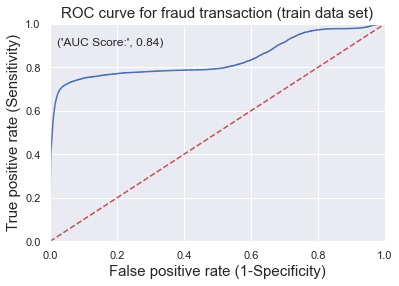

In [216]:
fpr, tpr, thresholds = roc_curve(ytrain, ytrain_prob)

# plot the ROC curve
plt.plot(fpr, tpr)

# set limits for x and y axes
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# plot the straight line showing worst prediction for the model
plt.plot([0, 1], [0, 1],'r--')

# add plot and axes labels
# set text size using 'fontsize'
plt.title('ROC curve for fraud transaction (train data set)', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)

# add the AUC score to the plot
# 'x' and 'y' gives position of the text
# 's' is the text 
# use round() to round-off the AUC score upto 4 digits
plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(roc_auc_score(ytrain, ytrain_prob),4)))
                               
# plot the grid
plt.grid(True)

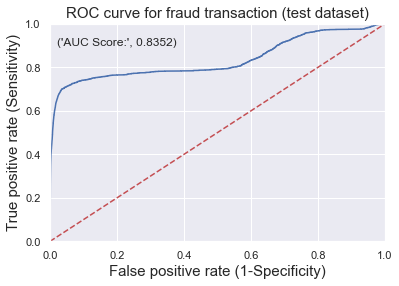

In [217]:
fpr, tpr, thresholds = roc_curve(ytest, ytest_prob)

# plot the ROC curve
plt.plot(fpr, tpr)

# set limits for x and y axes
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# plot the straight line showing worst prediction for the model
plt.plot([0, 1], [0, 1],'r--')

# add plot and axes labels
# set text size using 'fontsize'
plt.title('ROC curve for fraud transaction (test dataset)', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)

# add the AUC score to the plot
# 'x' and 'y' gives position of the text
# 's' is the text 
# use round() to round-off the AUC score upto 4 digits
plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(roc_auc_score(ytest, ytest_prob),4)))
                               
# plot the grid
plt.grid(True)

In [99]:
from sklearn.metrics import confusion_matrix,classification_report,cohen_kappa_score
from matplotlib.colors import ListedColormap

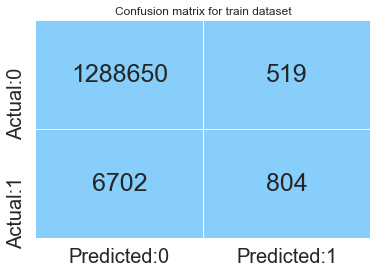

In [219]:
cm = confusion_matrix(ytrain, ypred_train)

# label the confusion matrix  
# pass the matrix as 'data'
# pass the required column names to the parameter, 'columns'
# pass the required row names to the parameter, 'index'
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])

# plot a heatmap to visualize the confusion matrix
# 'annot' prints the value of each grid 
# 'fmt = d' returns the integer value in each grid
# 'cmap' assigns color to each grid
# as we do not require different colors for each grid in the heatmap,
# use 'ListedColormap' to assign the specified color to the grid
# 'cbar = False' will not return the color bar to the right side of the heatmap
# 'linewidths' assigns the width to the line that divides each grid
# 'annot_kws = {'size':25})' assigns the font size of the annotated text 
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = ListedColormap(['lightskyblue']), cbar = False, 
            linewidths = 0.1, annot_kws = {'size':25})

# set the font size of x-axis ticks using 'fontsize'
plt.xticks(fontsize = 20)

# set the font size of y-axis ticks using 'fontsize'
plt.yticks(fontsize = 20)

# display the plot
plt.title('Confusion matrix for train dataset')
plt.show()

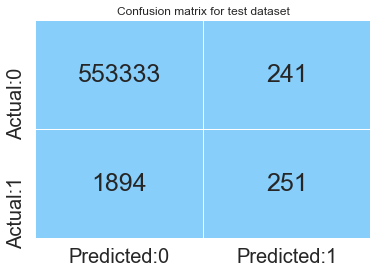

In [220]:
cm = confusion_matrix(ytest, ypred_test)

# label the confusion matrix  
# pass the matrix as 'data'
# pass the required column names to the parameter, 'columns'
# pass the required row names to the parameter, 'index'
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])

# plot a heatmap to visualize the confusion matrix
# 'annot' prints the value of each grid 
# 'fmt = d' returns the integer value in each grid
# 'cmap' assigns color to each grid
# as we do not require different colors for each grid in the heatmap,
# use 'ListedColormap' to assign the specified color to the grid
# 'cbar = False' will not return the color bar to the right side of the heatmap
# 'linewidths' assigns the width to the line that divides each grid
# 'annot_kws = {'size':25})' assigns the font size of the annotated text 
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = ListedColormap(['lightskyblue']), cbar = False, 
            linewidths = 0.1, annot_kws = {'size':25})

# set the font size of x-axis ticks using 'fontsize'
plt.xticks(fontsize = 20)

# set the font size of y-axis ticks using 'fontsize'
plt.yticks(fontsize = 20)

# display the plot
plt.title('Confusion matrix for test dataset')
plt.show()

In [221]:
acc_table = classification_report(ytrain, ypred_train)

# print the table

print('Train Dataset Classification report:')
print(acc_table)

Train Dataset Classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00   1289169
           1       0.61      0.11      0.18      7506

    accuracy                           0.99   1296675
   macro avg       0.80      0.55      0.59   1296675
weighted avg       0.99      0.99      0.99   1296675



In [222]:
acc_table = classification_report(ytest, ypred_test)

# print the table
print('Test Dataset Classification report:')
print(acc_table)

Test Dataset Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.51      0.12      0.19      2145

    accuracy                           1.00    555719
   macro avg       0.75      0.56      0.59    555719
weighted avg       0.99      1.00      0.99    555719



In [223]:
df_odds = pd.DataFrame(np.exp(logreg.params), columns= ['Odds']) 

# print the dataframe
df_odds.sort_values('Odds',ascending=False).head(5)

,Odds
category_grocery_pos,8.588491
category_gas_transport,6.815751
category_grocery_net,5.954717
amt,5.283372
category_misc_net,4.880806


In [327]:
df_odds.values

array([[4.28124420e-04],
       [5.28337174e+00],
       [9.49654752e-01],
       [1.00616859e+00],
       [1.04859845e+00],
       [1.05099375e+00],
       [1.01172230e+00],
       [1.98908261e+00],
       [1.01422813e+00],
       [9.50327627e-01],
       [9.29271196e-01],
       [6.81575147e+00],
       [5.95471707e+00],
       [8.58849135e+00],
       [7.12559194e-01],
       [6.82317346e-01],
       [9.04597039e-01],
       [4.88080619e+00],
       [1.20568697e+00],
       [1.27871967e+00],
       [3.15908853e+00],
       [1.29037793e+00],
       [9.94661623e-02],
       [1.42719271e+00],
       [1.84517903e+00],
       [1.27838557e+00],
       [1.31176676e+00]])

In [329]:
df_odds.index

Index(['const', 'amt', 'city_pop', 'merch_lat', 'merch_long', 'day_no',
       'min_day', 'hr_day', 'weekday_no', 'month', 'category_food_dining',
       'category_gas_transport', 'category_grocery_net',
       'category_grocery_pos', 'category_health_fitness', 'category_home',
       'category_kids_pets', 'category_misc_net', 'category_misc_pos',
       'category_personal_care', 'category_shopping_net',
       'category_shopping_pos', 'category_travel', 'gender_M',
       'age_group_Senior citizen', 'age_group_Very young age',
       'age_group_Young age'],
      dtype='object')

In [332]:
for i in df_odds.values:
    for j in df_odds.index:
        
        print(
'odds_',j,' =', i,' it implies that the odds of detecting a fraud transaction  increases by a factor of ',i,' due to one unit increase in the', j,' keeping other variables constant'
)

odds_ const  = [0.00042812]  it implies that the odds of detecting a fraud transaction  increases by a factor of  [0.00042812]  due to one unit increase in the const  keeping other variables constant
odds_ amt  = [0.00042812]  it implies that the odds of detecting a fraud transaction  increases by a factor of  [0.00042812]  due to one unit increase in the amt  keeping other variables constant
odds_ city_pop  = [0.00042812]  it implies that the odds of detecting a fraud transaction  increases by a factor of  [0.00042812]  due to one unit increase in the city_pop  keeping other variables constant
odds_ merch_lat  = [0.00042812]  it implies that the odds of detecting a fraud transaction  increases by a factor of  [0.00042812]  due to one unit increase in the merch_lat  keeping other variables constant
odds_ merch_long  = [0.00042812]  it implies that the odds of detecting a fraud transaction  increases by a factor of  [0.00042812]  due to one unit increase in the merch_long  keeping other

odds_ day_no  = [1.05099375]  it implies that the odds of detecting a fraud transaction  increases by a factor of  [1.05099375]  due to one unit increase in the day_no  keeping other variables constant
odds_ min_day  = [1.05099375]  it implies that the odds of detecting a fraud transaction  increases by a factor of  [1.05099375]  due to one unit increase in the min_day  keeping other variables constant
odds_ hr_day  = [1.05099375]  it implies that the odds of detecting a fraud transaction  increases by a factor of  [1.05099375]  due to one unit increase in the hr_day  keeping other variables constant
odds_ weekday_no  = [1.05099375]  it implies that the odds of detecting a fraud transaction  increases by a factor of  [1.05099375]  due to one unit increase in the weekday_no  keeping other variables constant
odds_ month  = [1.05099375]  it implies that the odds of detecting a fraud transaction  increases by a factor of  [1.05099375]  due to one unit increase in the month  keeping other v

odds_ weekday_no  = [0.9292712]  it implies that the odds of detecting a fraud transaction  increases by a factor of  [0.9292712]  due to one unit increase in the weekday_no  keeping other variables constant
odds_ month  = [0.9292712]  it implies that the odds of detecting a fraud transaction  increases by a factor of  [0.9292712]  due to one unit increase in the month  keeping other variables constant
odds_ category_food_dining  = [0.9292712]  it implies that the odds of detecting a fraud transaction  increases by a factor of  [0.9292712]  due to one unit increase in the category_food_dining  keeping other variables constant
odds_ category_gas_transport  = [0.9292712]  it implies that the odds of detecting a fraud transaction  increases by a factor of  [0.9292712]  due to one unit increase in the category_gas_transport  keeping other variables constant
odds_ category_grocery_net  = [0.9292712]  it implies that the odds of detecting a fraud transaction  increases by a factor of  [0.929

odds_ category_shopping_net  = [0.90459704]  it implies that the odds of detecting a fraud transaction  increases by a factor of  [0.90459704]  due to one unit increase in the category_shopping_net  keeping other variables constant
odds_ category_shopping_pos  = [0.90459704]  it implies that the odds of detecting a fraud transaction  increases by a factor of  [0.90459704]  due to one unit increase in the category_shopping_pos  keeping other variables constant
odds_ category_travel  = [0.90459704]  it implies that the odds of detecting a fraud transaction  increases by a factor of  [0.90459704]  due to one unit increase in the category_travel  keeping other variables constant
odds_ gender_M  = [0.90459704]  it implies that the odds of detecting a fraud transaction  increases by a factor of  [0.90459704]  due to one unit increase in the gender_M  keeping other variables constant
odds_ age_group_Senior citizen  = [0.90459704]  it implies that the odds of detecting a fraud transaction  inc

odds_ age_group_Very young age  = [0.09946616]  it implies that the odds of detecting a fraud transaction  increases by a factor of  [0.09946616]  due to one unit increase in the age_group_Very young age  keeping other variables constant
odds_ age_group_Young age  = [0.09946616]  it implies that the odds of detecting a fraud transaction  increases by a factor of  [0.09946616]  due to one unit increase in the age_group_Young age  keeping other variables constant
odds_ const  = [1.42719271]  it implies that the odds of detecting a fraud transaction  increases by a factor of  [1.42719271]  due to one unit increase in the const  keeping other variables constant
odds_ amt  = [1.42719271]  it implies that the odds of detecting a fraud transaction  increases by a factor of  [1.42719271]  due to one unit increase in the amt  keeping other variables constant
odds_ city_pop  = [1.42719271]  it implies that the odds of detecting a fraud transaction  increases by a factor of  [1.42719271]  due to 

In [198]:
kappa = cohen_kappa_score(y, ypred)

# print the kappa value
print('kappa value:',kappa)

kappa value: 0.005501898169676389


In [199]:
print('AIC:', logreg.aic)

AIC: 73994.65804669287


# xgboost

In [86]:
from xgboost import XGBClassifier

In [87]:
x_train=df_final
ytrain=df_target

In [88]:
x_tests=dft_final
ytest=dft_target

In [89]:
xg=XGBClassifier(max_depth=200,gamma=0.2,learning_rate=0.2)

In [90]:
model=xg.fit(x_train,ytrain)

C:\Users\DELL\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[20:35:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [91]:
ytrain_pred=model.predict(x_train)
ytest_pred=model.predict(x_tests)

In [92]:
acc_table = classification_report(ytrain, ytrain_pred)

# print the table

print('Train Dataset Classification report:')
print(acc_table)

Train Dataset Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1289169
           1       1.00      1.00      1.00      7506

    accuracy                           1.00   1296675
   macro avg       1.00      1.00      1.00   1296675
weighted avg       1.00      1.00      1.00   1296675



In [93]:
roc_auc_score(ytrain,ytrain_pred)

0.9998001598721022

In [94]:
acc_table = classification_report(ytest, ytest_pred)

# print the table

print('Test Dataset Classification report:')
print(acc_table)

Test Dataset Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.91      0.74      0.82      2145

    accuracy                           1.00    555719
   macro avg       0.95      0.87      0.91    555719
weighted avg       1.00      1.00      1.00    555719



In [95]:
roc_auc_score(ytest,ytest_pred)

0.870479435841971

In [ ]:
#confusion_matrix

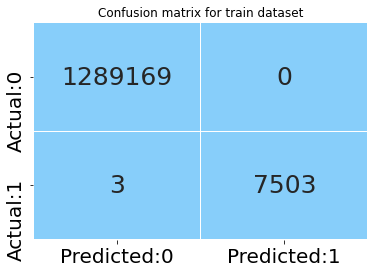

In [100]:
cm = confusion_matrix(ytrain, ytrain_pred)

conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])

sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = ListedColormap(['lightskyblue']), cbar = False, 
            linewidths = 0.1, annot_kws = {'size':25})

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title('Confusion matrix for train dataset')
plt.show()

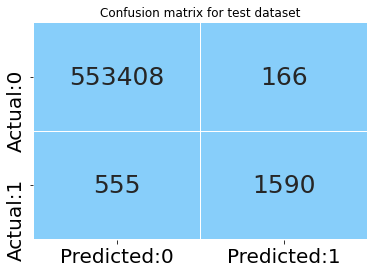

In [101]:
cm = confusion_matrix(ytest, ytest_pred)
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])

sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = ListedColormap(['lightskyblue']), cbar = False, 
            linewidths = 0.1, annot_kws = {'size':25})

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title('Confusion matrix for test dataset')
plt.show()

In [106]:
from sklearn.model_selection import  KFold,cross_val_score

In [107]:
#bias error, variance error
kf = KFold(n_splits = 10, shuffle = True, random_state = 0)
scores = cross_val_score(xg,x_train,ytrain, cv = kf, scoring = 'roc_auc')

print('Bias Error:',1-np.mean(scores))
print('Variance Error:',np.std(scores, ddof = 1))

C:\Users\DELL\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[21:18:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\DELL\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[22:50:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\DELL\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[22:58:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\DELL\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[23:05:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\DELL\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[23:18:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\DELL\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[23:26:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\DELL\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[23:34:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\DELL\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[23:41:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\DELL\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[23:49:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\DELL\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[23:57:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Bias Error: 0.0016111887697091154
Variance Error: 0.0003687808082842194


In [103]:
#roc_curve
from sklearn.metrics import roc_auc_score,roc_curve

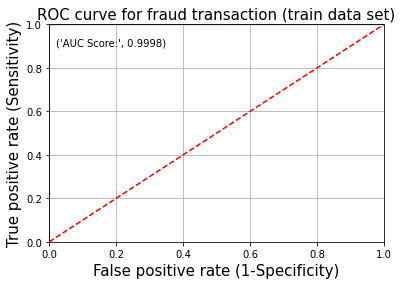

In [104]:
fpr, tpr, thresholds = roc_curve(ytrain, ytrain_pred)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC curve for fraud transaction (train data set)', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)

plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(roc_auc_score(ytrain, ytrain_pred),4)))
plt.grid(True)

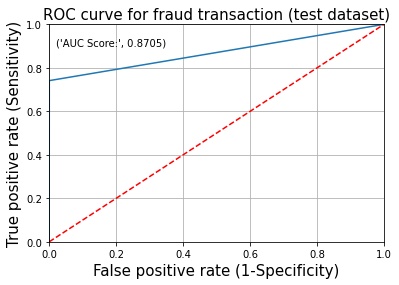

In [105]:
fpr, tpr, thresholds = roc_curve(ytest, ytest_pred)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC curve for fraud transaction (test dataset)', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)
plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(roc_auc_score(ytest, ytest_pred),4)))
plt.grid(True)

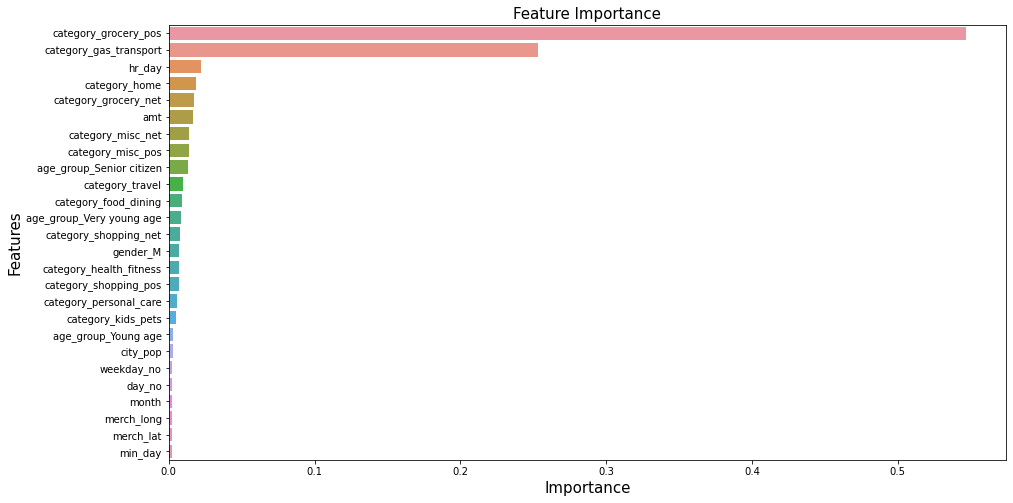

In [108]:
plt.figure(figsize=(15,8))
important_features = pd.DataFrame({'Features': x_train.columns,
                                  'Importance':model.feature_importances_})
important_features = important_features.sort_values('Importance', ascending = False)
sns.barplot(x = 'Importance', y = 'Features', data = important_features)
plt.title('Feature Importance', fontsize = 15)
plt.xlabel('Importance', fontsize = 15)
plt.ylabel('Features', fontsize = 15)
plt.show()

In [109]:
important_features

,Features,Importance
12,category_grocery_pos,0.546776
10,category_gas_transport,0.253347
6,hr_day,0.022194
14,category_home,0.018965
11,category_grocery_net,0.017183
0,amt,0.016757
16,category_misc_net,0.014017
17,category_misc_pos,0.013608
23,age_group_Senior citizen,0.012878
21,category_travel,0.009610


In [ ]:
########################33

# Gradient boost

In [110]:
from sklearn.ensemble import GradientBoostingClassifier

In [111]:
x_train=df_final
ytrain=df_target

In [112]:
x_tests=dft_final
ytest=dft_target

In [113]:
gb=GradientBoostingClassifier(max_depth=200,learning_rate=0.2)

In [114]:
model1=gb.fit(x_train,ytrain)

In [115]:
ytrain_pred1=model1.predict(x_train)
ytest_pred1=model1.predict(x_tests)

In [116]:
acc_table = classification_report(ytrain, ytrain_pred1)

# print the table

print('Train Dataset Classification report:')
print(acc_table)

Train Dataset Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1289169
           1       1.00      1.00      1.00      7506

    accuracy                           1.00   1296675
   macro avg       1.00      1.00      1.00   1296675
weighted avg       1.00      1.00      1.00   1296675



In [117]:
acc_table = classification_report(ytest, ytest_pred1)

# print the table

print('Test Dataset Classification report:')
print(acc_table)

Test Dataset Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.66      0.75      0.70      2145

    accuracy                           1.00    555719
   macro avg       0.83      0.87      0.85    555719
weighted avg       1.00      1.00      1.00    555719



In [ ]:
#confusion matrix

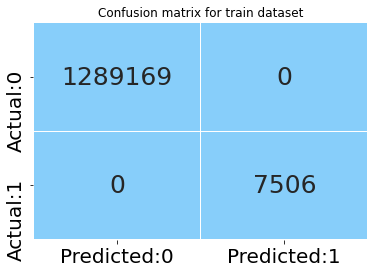

In [118]:
cm = confusion_matrix(ytrain, ytrain_pred1)

conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])

sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = ListedColormap(['lightskyblue']), cbar = False, 
            linewidths = 0.1, annot_kws = {'size':25})

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title('Confusion matrix for train dataset')
plt.show()

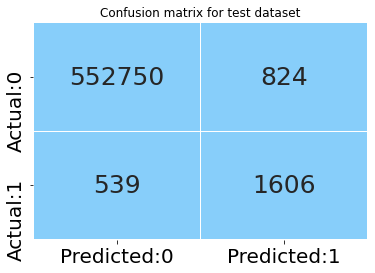

In [119]:
cm = confusion_matrix(ytest, ytest_pred1)
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = ListedColormap(['lightskyblue']), cbar = False, 
            linewidths = 0.1, annot_kws = {'size':25})
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title('Confusion matrix for test dataset')
plt.show()

In [ ]:
#bias , variance error

In [ ]:
#roc_curve

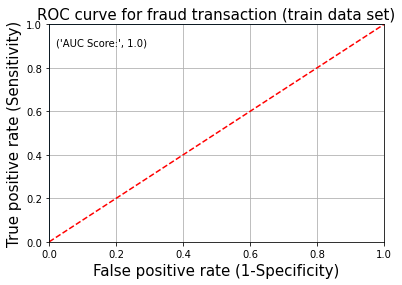

In [120]:
fpr, tpr, thresholds = roc_curve(ytrain, ytrain_pred1)

plt.plot(fpr, tpr)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC curve for fraud transaction (train data set)', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)
plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(roc_auc_score(ytrain, ytrain_pred1),4)))
plt.grid(True)

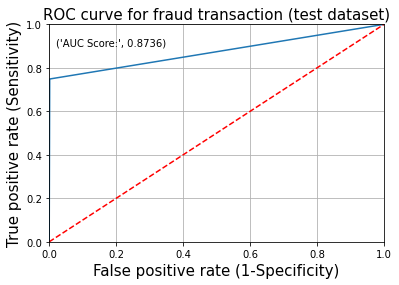

In [121]:
fpr, tpr, thresholds = roc_curve(ytest, ytest_pred1)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC curve for fraud transaction (test dataset)', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)
plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(roc_auc_score(ytest, ytest_pred1),4)))
plt.grid(True)

In [ ]:
#########################################